# Software empleado


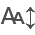

In [1]:
#
import os, sys
sys.path.append(os.path.abspath('notebooks/'))

#
import pandas as pd
import numpy as np

#
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)

In [2]:
#
def sort_by_column(df, column, custom_order=None, secondary_column=None):
    if custom_order:
        df[column] = pd.Categorical(df[column], categories=custom_order, ordered=True)
    if secondary_column:
        return df.sort_values(by=[column, secondary_column])
    return df.sort_values(column)

### Análisis de la varianza


In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import shapiro, levene, kruskal
import pingouin as pg
import scikit_posthocs as sp

# ---------------------
# Prueba 1: ANOVA + Tukey
# ---------------------
def run_anova_tukey(df, metric, group_col, alpha=0.05):
    model = ols(f'{metric} ~ C({group_col})', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    display(anova_table)

    p_value = anova_table.loc[f'C({group_col})', 'PR(>F)']
    if p_value < alpha:
        tukey = pairwise_tukeyhsd(df[metric], df[group_col], alpha=alpha)
        tukey_df = pd.DataFrame(
            data=tukey._results_table.data[1:],
            columns=tukey._results_table.data[0]
        )
        print("\n🔎 Comparaciones por pares (Tukey HSD):")
        display(tukey_df)

# ---------------------
# Prueba 2: Welch + Games–Howell
# ---------------------

def enrich_posthoc_table(df, alpha=0.05):
    """Añade columnas de interpretación a tabla de comparaciones post-hoc."""
    def interpret_significance(p):
        return "Significativa" if p < alpha else "No significativa"

    df = df.copy()
    df['Significance'] = df['pval'].apply(interpret_significance)
    return df

def run_welch_gameshowell(df, metric, group_col, alpha=0.05):
    welch = pg.welch_anova(dv=metric, between=group_col, data=df)
    display(welch)

    if welch['p-unc'][0] < alpha:
        gh = pg.pairwise_gameshowell(data=df, dv=metric, between=group_col)
        
        def interpret_significance(p):
            return "Significative" if p < alpha else "Non significative"
        
        gh['Significance'] = gh['pval'].apply(interpret_significance)
        
        print("\n📊 Welch ANOVA + Games-Howell")
        display(gh)

# ---------------------
# Prueba 3: Kruskal + Dunn
# ---------------------
def run_kruskal_dunn(df, metric, group_col, alpha=0.05):
    groups = [df[df[group_col] == g][metric] for g in df[group_col].unique()]
    kw_stat, kw_p = kruskal(*groups)
    display(pd.DataFrame({'H': [kw_stat], 'pval': [kw_p]}))

    if kw_p < alpha:
        dunn = sp.posthoc_dunn(df, val_col=metric, group_col=group_col, p_adjust='bonferroni')
        print("\n🔎 Comparaciones por pares (Dunn con Bonferroni):")
        display(dunn)

# =====================
# Función principal
# =====================
def run_group_comparison(df, metric, group_col='pred_model_type', alpha=0.05):
    
    print(f"\n{'='*60}")
    print(f"ANÁLISIS ESTADÍSTICO PARA: {metric.upper()}")
    print(f"{'='*60}")
    
    # 1. Verificar supuestos
    model = ols(f'{metric} ~ C({group_col})', data=df).fit()
    _, p_normality = shapiro(model.resid)
    norm_ok = p_normality >= alpha

    groups = [df[df[group_col] == g][metric] for g in df[group_col].unique()]
    _, p_homog = levene(*groups)
    homog_ok = p_homog >= alpha

    print(f"• Normalidad (Shapiro-Wilk): p = {p_normality:.4f} {'✅' if norm_ok else '❌'}")
    print(f"• Homocedasticidad (Levene): p = {p_homog:.4f} {'✅' if homog_ok else '❌'}")

    # 2. Selección de prueba
    if norm_ok and homog_ok:
        print("\n📊 ANOVA clásico + Tukey HSD")
        run_anova_tukey(df, metric, group_col, alpha)
    elif norm_ok and not homog_ok:
        print("\n📊 Welch ANOVA + Games-Howell")
        run_welch_gameshowell(df, metric, group_col, alpha)
    else:
        print("\n📊 Kruskal-Wallis + Dunn")
        run_kruskal_dunn(df, metric, group_col, alpha)

### Gráfica de dispersión de Cobertura - Tamaño Medio del Conjunto

In [4]:
from typing import Iterable, Tuple, Optional, Union
import matplotlib.pyplot as plt

def plot_coverage_vs_interval_width(
    mean_pred_interval_widths,
    empirical_coverages,
    model_types,
    colors,
    confidence_level=None,
    figsize=(8, 6),
    dpi=100
) -> None:

    # Convertir a listas
    mean_pred_interval_widths = list(mean_pred_interval_widths)
    empirical_coverages = list(empirical_coverages)
    model_types = list(model_types)
    colors = list(colors)

    if not (len(mean_pred_interval_widths) == len(empirical_coverages) == len(model_types) == len(colors)):
        raise ValueError("All input iterables must have the same length.")

    # Multiplicar cobertura por 100 para mostrar en %
    empirical_coverages_percent = [c * 100 for c in empirical_coverages]
    confidence_level_percent = confidence_level * 100 if confidence_level is not None else None

    # Crear figura
    plt.figure(figsize=figsize, dpi=dpi)
    plt.grid(True, zorder=0)

    # Scatter plot
    plt.scatter(
        mean_pred_interval_widths,
        empirical_coverages_percent,
        c=colors,
        marker='o',
        s=100,
        edgecolor='white',
        linewidth=0.5,
        zorder=3
    )

    # Línea de referencia
    if confidence_level_percent is not None:
        plt.axhline(y=confidence_level_percent, color='black', linestyle='--', linewidth=1.0, zorder=2)

    # Etiquetas y título
    plt.xlabel("Amplitud Media de Intervalo de Predicción", fontsize=12)
    plt.ylabel("Cobertura empírica (%)", fontsize=12)

    # Legend
    seen = set()
    legend_elements = []
    for model, color in zip(model_types, colors):
        if model not in seen:
            legend_elements.append(
                plt.Line2D([0], [0], marker='o', color='w', label=model,
                           markerfacecolor=color, markersize=10, markeredgecolor='white')
            )
            seen.add(model)
    plt.legend(handles=legend_elements, title="Método")

    # Ticks del eje Y cada 1%
    ymin, ymax = plt.gca().get_ylim()
    plt.yticks(np.arange(np.floor(ymin), np.ceil(ymax) + 1, 1))

    plt.tight_layout()
    plt.show()

#-------------------------------------------------------------------------------------------

def plot_coverage_vs_set_size(
    mean_set_sizes: Iterable[float], 
    empirical_coverages: Iterable[float], 
    model_types: Iterable[str],
    colors: Iterable[str],
    confidence_level: float = None,
    figsize: Tuple[float, float] = (8, 6),
    dpi: int = 100 
) -> None:

    # Convertimos a listas para poder indexar y hacer validaciones
    mean_pred_set_sizes = list(mean_set_sizes)
    empirical_coverages = list(empirical_coverages)
    model_types = list(model_types)
    colors = list(colors)

    if not (len(mean_pred_set_sizes) == len(empirical_coverages) == len(model_types) == len(colors)):
        raise ValueError("All input iterables must have the same length.")
    
    # Multiplicar cobertura por 100 para mostrar en %
    empirical_coverages_percent = [c * 100 for c in empirical_coverages]
    confidence_level_percent = confidence_level * 100 if confidence_level is not None else None
    
    plt.figure(figsize=figsize, dpi=dpi)
    plt.grid(True, zorder=0)

    # Graficar todos los puntos como círculos
    plt.scatter(
        mean_pred_set_sizes,
        empirical_coverages_percent,
        c=colors,
        marker='o',
        s=100,
        edgecolor='white',
        linewidth=0.5,
        zorder=3
    )
    
    # Línea de referencia
    if confidence_level_percent is not None:
        plt.axhline(y=confidence_level_percent, color='black', linestyle='--', linewidth=1.0, zorder=2)

    # Etiquetas y título
    plt.xlabel("Tamaño Medio de Conjunto de Predicción", fontsize=12)
    plt.ylabel("Cobertura empírica (%)", fontsize=12)

    # Legend
    seen = set()
    legend_elements = []
    for model, color in zip(model_types, colors):
        if model not in seen:
            legend_elements.append(
                plt.Line2D([0], [0], marker='o', color='w', label=model,
                           markerfacecolor=color, markersize=10, markeredgecolor='white')
            )
            seen.add(model)
    
    # Obtener los límites actuales del eje Y
    ymin, ymax = plt.gca().get_ylim()

    # Ajustar los ticks cada 1 dentro del rango visible
    plt.yticks(np.arange(np.floor(ymin), np.ceil(ymax) + 1, 1))

    plt.legend(handles=legend_elements, title="Método")
    plt.tight_layout()
    plt.show()

### Histograma de anchos de intervalo con tasa de cobertura

In [5]:
import seaborn as sns

def plot_interval_width_histogram(
    df: pd.DataFrame,
    pred_model_type: str,
    confidence: float,
    bins: int = 30,
    figsize: Tuple[float, float] = (8, 5),
    dpi: int = 150
) -> plt.Figure:
    
    # Filtrar datos
    filtered_data = df.query(
        "pred_model_type == @pred_model_type and confidence == @confidence"
    ).copy()

    # Etiquetas de cobertura
    filtered_data['coverage_status'] = filtered_data['is_covered'].map({
        True: 'Cubre valor real',
        False: 'No cubre valor real'
    })

    # Crear figura
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    sns.histplot(
        data=filtered_data,
        x='pred_interval_width',
        hue='coverage_status',
        bins=bins,
        multiple='stack',
        palette=['#4CAF50', '#F44336'],  # verde y rojo
        edgecolor='white',
        linewidth=0.5,
        ax=ax,
        kde=True,
        legend=True
    )

    # Cobertura empírica
    coverage_rate = filtered_data['is_covered'].mean()

    # Personalización
    ax.set_title(
        f"Modelo: {pred_model_type} | "+ 
        f"Nivel de confianza: {confidence*100:.1f} % | " + 
        f"Cobertura empírica: {coverage_rate:.1%}",
        fontsize=13,
        pad=10
    )
    ax.set_xlabel("Amplitud del intervalo de predicción", fontsize=13)
    ax.set_ylabel("Frecuencia", fontsize=13)
    ax.tick_params(axis='both', labelsize=12)

    plt.tight_layout()
    return fig

### C

In [6]:
import matplotlib.ticker as mticker

def plot_coverage_by_interval(
    df: pd.DataFrame, 
    bin_width: float = 0.5,
    vmin=0.9, 
    vmax=1.0, 
    center=0.95, 
    figsize=(9,7), 
    dpi=150, 
    bins=None
) -> plt.Figure:
    
    sns.set(style="white")
    
    # Copia temporal y agrupar en franjas de bin_width
    df_temp = df.assign(
        interval_bin=lambda x: np.floor(x['pred_interval_width'] / bin_width) * bin_width
    )

    # Cobertura media y conteo
    coverage_matrix = df_temp.pivot_table(
        index='interval_bin',
        columns='pred_model_type',
        values='is_covered',
        aggfunc='mean'
    ).sort_index()

    count_matrix = df_temp.pivot_table(
        index='interval_bin',
        columns='pred_model_type',
        values='is_covered',
        aggfunc='count'
    ).sort_index()

    # Anotaciones
    annotations = coverage_matrix.mul(100).round(2).astype(str) + "%\n(n=" + count_matrix.astype(str) + ")"

    # Crear figura
    plt.figure(figsize=figsize, dpi=dpi)
    ax = sns.heatmap(
        coverage_matrix,
        annot=annotations,
        fmt="",
        cmap="RdBu",
        center=center,
        vmin=vmin,
        vmax=vmax,
        cbar_kws={'label': 'Cobertura empírica'},
        linecolor='white',   # color de las líneas
        linewidths=0.5       # grosor de las líneas
    )

    # Colorbar con ticks cada 1%
    cbar = ax.collections[0].colorbar
    ticks = np.arange(vmin, vmax + 0.001, 0.01)
    cbar.set_ticks(ticks)
    cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%"))
    
    # Etiquetas de intervalos en el eje Y
    y_labels = [f"[{bin_val:.1f}, {bin_val + bin_width:.1f})" for bin_val in coverage_matrix.index]
    ax.set_yticklabels(y_labels, rotation=0)


    # Labels y título
    ax.set_xlabel("Método")
    ax.set_ylabel("Amplitud del intervalo")
    plt.tight_layout()
    return plt.gcf()

#-------------------------------------------------------------------------------------------

def plot_coverage_by_set_size(
    df: pd.DataFrame,
    vmin=0.9,
    vmax=1.0,
    center=0.95,
    figsize=(9,7),
    dpi=110
) -> plt.Figure:

    sns.set(style="white")

    # Cobertura media y conteo
    coverage_matrix = df.pivot_table(
        index='pred_set_size',
        columns='pred_model_type',
        values='is_covered',
        aggfunc='mean'
    ).sort_index()

    count_matrix = df.pivot_table(
        index='pred_set_size',
        columns='pred_model_type',
        values='is_covered',
        aggfunc='count'
    ).sort_index()

    # Anotaciones
    annotations = coverage_matrix.mul(100).round(2).astype(str) + "%\n(n=" + count_matrix.astype(str) + ")"

    # Crear figura
    plt.figure(figsize=figsize, dpi=dpi)
    ax = sns.heatmap(
        coverage_matrix,
        annot=annotations,
        fmt="",
        cmap="RdBu",
        center=center,
        vmin=vmin,
        vmax=vmax,
        cbar_kws={'label': 'Cobertura empírica'},
        linecolor='white',
        linewidths=0.5
    )

    # Colorbar con ticks cada 1%
    cbar = ax.collections[0].colorbar
    ticks = np.arange(vmin, vmax + 0.001, 0.01)
    cbar.set_ticks(ticks)
    cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%"))

    # Labels eje Y (tamaños de conjunto)
    ax.set_yticklabels([str(int(s)) for s in coverage_matrix.index], rotation=0)

    # Labels y título
    ax.set_xlabel("Método")
    ax.set_ylabel("Tamaño del conjunto")
    plt.tight_layout()
    return plt.gcf()

### D

In [7]:
def plot_interval_predictions(
    pred_point_values,
    pred_lower_bound,
    pred_upper_bound,
    true_values,
    figsize: Tuple[float, float] = (10, 6),
    dpi=150
) -> None:
    
    # Ordena por los valores predichos
    order = np.argsort(true_values)
    y_true = true_values[order]
    y_pred = pred_point_values[order]
    y_lower = pred_lower_bound[order]
    y_upper = pred_upper_bound[order]
    
    x = np.arange(len(y_true))
    
    # Grafica
    plt.figure(figsize=figsize, dpi=dpi)
    plt.plot(x, y_true, label='Valor verdadero', 
             color='black', linewidth=2, marker='s', markersize=4)
    plt.plot(x, y_pred, label='Predicción puntual', 
             color='steelblue', linestyle='--', marker='o', markersize=4)
    plt.fill_between(x, y_lower, y_upper, 
                     color='lightcoral', alpha=0.5, label='Intervalo de confianza')
    
    # Identificar valores fuera del intervalo
    outside_mask = (y_true < y_lower) | (y_true > y_upper)
    
    # Graficar los puntos fuera del intervalo en rojo
    plt.scatter(x[outside_mask], y_true[outside_mask], 
                color='red', marker='x', s=50, label='Fuera del intervalo')
    
    plt.xlabel('Instancia (ordenada por valor verdadero)')
    plt.ylabel('Valor')
    plt.title('Predicción con intervalos de confianza')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# PROBLEMA 1: ESTIMACIÓN DE EDAD

## 1.1. Carga de los resultados y obtención de métricas

In [10]:
# Carga de datos
df_AE_by_instance = pd.read_csv('results/01_AE_maxillofacial_test_results.csv')

# Nueva columna: error absoluto
df_AE_by_instance['absolute_error'] = (df_AE_by_instance['true_value'] - df_AE_by_instance['pred_point_value']).abs()

# Nueva columna: error cuadrático
df_AE_by_instance['squared_error'] = (df_AE_by_instance['true_value'] - df_AE_by_instance['pred_point_value']).pow(2)

# Nueva columna: tamaño del intervalo medio
df_AE_by_instance['pred_interval_width'] = df_AE_by_instance['pred_upper_bound'] - df_AE_by_instance['pred_lower_bound']

# Nueva columna: cobertura (true/false)
df_AE_by_instance['is_covered'] = (df_AE_by_instance['true_value'] >= df_AE_by_instance['pred_lower_bound']) & \
                          (df_AE_by_instance['true_value'] <= df_AE_by_instance['pred_upper_bound'])

# Nueva columna: interval score  
alpha = 1 - df_AE_by_instance['confidence']
df_AE_by_instance['interval_score'] = (
    (df_AE_by_instance['pred_upper_bound'] - df_AE_by_instance['pred_lower_bound']) 
    + (2 / alpha) * (df_AE_by_instance['pred_lower_bound'] - df_AE_by_instance['true_value']).clip(lower=0) 
    + (2 / alpha) * (df_AE_by_instance['true_value'] - df_AE_by_instance['pred_upper_bound']).clip(lower=0)
)

# Ordena por iteración y por tipo de predicción
custom_order = ['base', 'ICP', 'QR', 'CQR']
df_AE_by_instance = sort_by_column(df_AE_by_instance, 'pred_model_type', custom_order, 
                                   secondary_column='iteration')

display(df_AE_by_instance)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [11]:
# Agrupar y calcular métricas por ejecución
df_AE_by_run = (
    df_AE_by_instance
    .groupby(['pred_model_type', 'confidence', 'iteration'])
    .agg(
        mean_absolute_error=('absolute_error', 'mean'),
        mean_squared_error=('squared_error', 'mean'),
        empirical_coverage=('is_covered', 'mean'),
        mean_interval_width=('pred_interval_width', 'mean'),
        mean_interval_score=('interval_score', 'mean')
    )
    .reset_index()
)

# Ordena por iteración y por tipo de predicción
df_AE_by_run = sort_by_column(df_AE_by_run, 'pred_model_type', custom_order, secondary_column='iteration')

display(df_AE_by_run)

/tmp/ipykernel_17721/1776090412.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_model_type', 'confidence', 'iteration'])


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## 1.2. Análisis de las métricas para la estimación puntual de edad

### Tabla resumen por método y ejecución

In [15]:
# Pivot, reorganiza métricas y añade medias
pivot_point_metrics = (
    df_AE_by_run
    .pivot(
        index='iteration',
        columns=['pred_model_type', 'confidence'],
        values=['mean_absolute_error', 'mean_squared_error']
    )
    .swaplevel(axis=1)
    .sort_index(axis=1)
)

# Añadimos fila de medias
pivot_point_metrics.loc['Media'] = pivot_point_metrics.mean()

# Mostrar tabla con 2 decimales
styled_table = pivot_point_metrics.style.format("{:.2f}")
show(styled_table, allow_html=True)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Análisis de la varianza

In [16]:
for metric in ['mean_absolute_error', 'mean_squared_error']:
    run_group_comparison(df_AE_by_run, metric)


ANÁLISIS ESTADÍSTICO PARA: MEAN_ABSOLUTE_ERROR
• Normalidad (Shapiro-Wilk): p = 0.5275 ✅
• Homocedasticidad (Levene): p = 0.8649 ✅

📊 ANOVA clásico + Tukey HSD


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



🔎 Comparaciones por pares (Tukey HSD):


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



ANÁLISIS ESTADÍSTICO PARA: MEAN_SQUARED_ERROR
• Normalidad (Shapiro-Wilk): p = 0.5617 ✅
• Homocedasticidad (Levene): p = 0.7333 ✅

📊 ANOVA clásico + Tukey HSD


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



🔎 Comparaciones por pares (Tukey HSD):


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## 1.3. Análisis de las métricas para la estimación interválica de edad

### Tabla resumen por método y ejecución

In [13]:
# Pivot, ordenar métricas y añadir medias
pivot_intervalic_metrics = (
    df_AE_by_run
    .pivot(
        index='iteration',
        columns=['pred_model_type', 'confidence'],
        values=['empirical_coverage', 'mean_interval_width', 'mean_interval_score']
    )
    .swaplevel(axis=1)
    .sort_index(axis=1)
    .reindex(columns=['empirical_coverage', 'mean_interval_width', 'mean_interval_score'], level=0)
)

# Añadimos fila de medias
pivot_intervalic_metrics.loc['Media'] = pivot_intervalic_metrics.mean()

# Multiplicar columnas de cobertura por 100 (selección por nivel)
pivot_intervalic_metrics.loc[:, pd.IndexSlice['empirical_coverage', :, :]] *= 100

# Mostrar tabla con formato
styled_table = pivot_intervalic_metrics.style.format("{:.2f}")
show(styled_table, allow_html=True)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Análisis de la varianza

In [14]:
# Ejemplo de uso:
for metric in ['empirical_coverage', 'mean_interval_width']:
    run_group_comparison(df_AE_by_run, metric)


ANÁLISIS ESTADÍSTICO PARA: EMPIRICAL_COVERAGE
• Normalidad (Shapiro-Wilk): p = 0.2479 ✅
• Homocedasticidad (Levene): p = 0.5797 ✅

📊 ANOVA clásico + Tukey HSD


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



🔎 Comparaciones por pares (Tukey HSD):


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



ANÁLISIS ESTADÍSTICO PARA: MEAN_INTERVAL_WIDTH
• Normalidad (Shapiro-Wilk): p = 0.8276 ✅
• Homocedasticidad (Levene): p = 0.0084 ❌

📊 Welch ANOVA + Games-Howell


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



📊 Welch ANOVA + Games-Howell


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Gráfica de dispersión Cobertura empírica - Amplitud media del intervalo

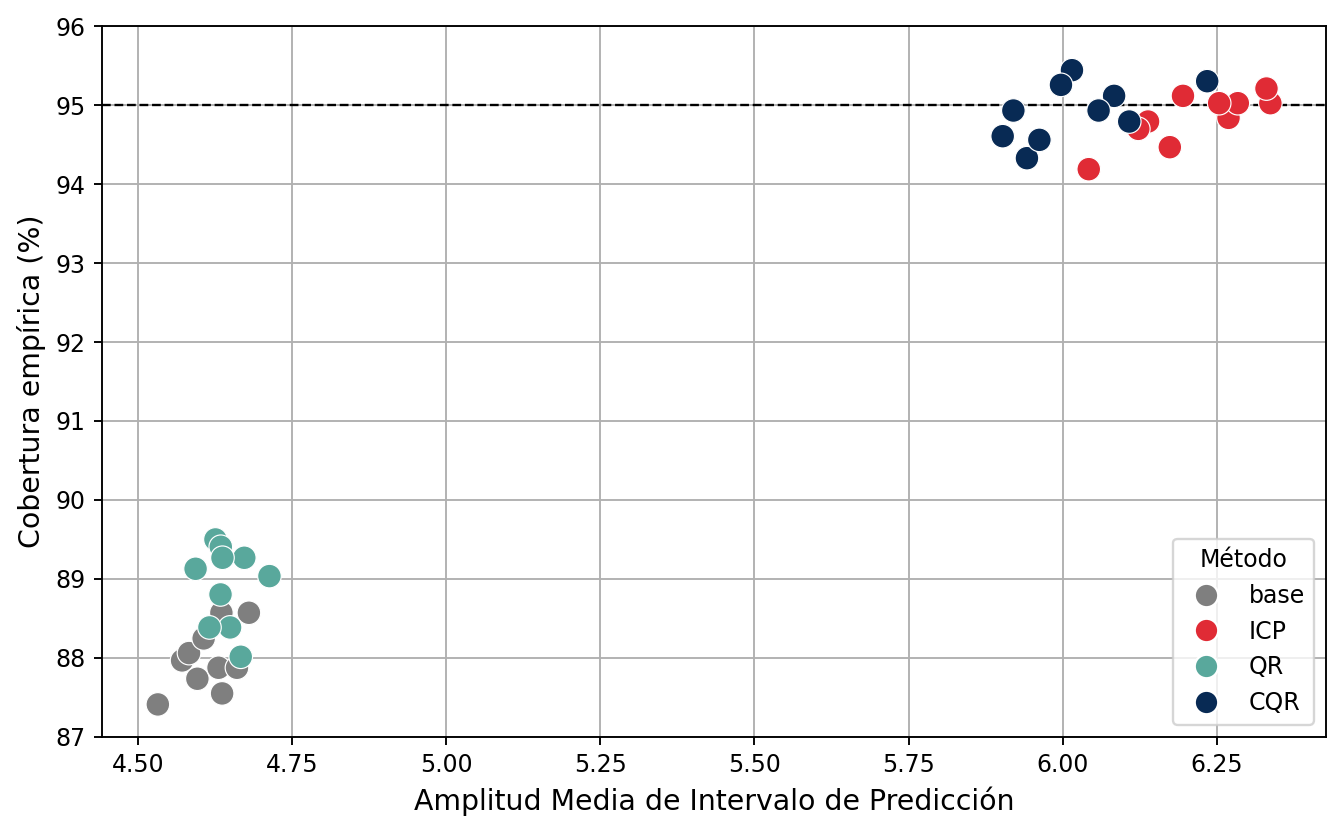

In [14]:
# Mapear colores
color_dict = {'base': '#7f7f7f', 'ICP': '#e02b35', 'QR': '#59a89c', 'CQR': '#082a54'}
df_AE_by_run_to_plot = df_AE_by_run.copy()
df_AE_by_run_to_plot['color'] = df_AE_by_run_to_plot['pred_model_type'].map(color_dict)

#
plot_coverage_vs_interval_width(
    mean_pred_interval_widths = df_AE_by_run_to_plot['mean_interval_width'],
    empirical_coverages = df_AE_by_run_to_plot['empirical_coverage'],
    model_types = df_AE_by_run_to_plot['pred_model_type'],
    colors = df_AE_by_run_to_plot['color'],
    confidence_level = 0.95,
    figsize=(8,5),
    dpi=170
)

## 1.4. Análisis de la cobertura en base al tamaño del intervalo

### Histograma del ancho del intervalo con distinción de cobertura

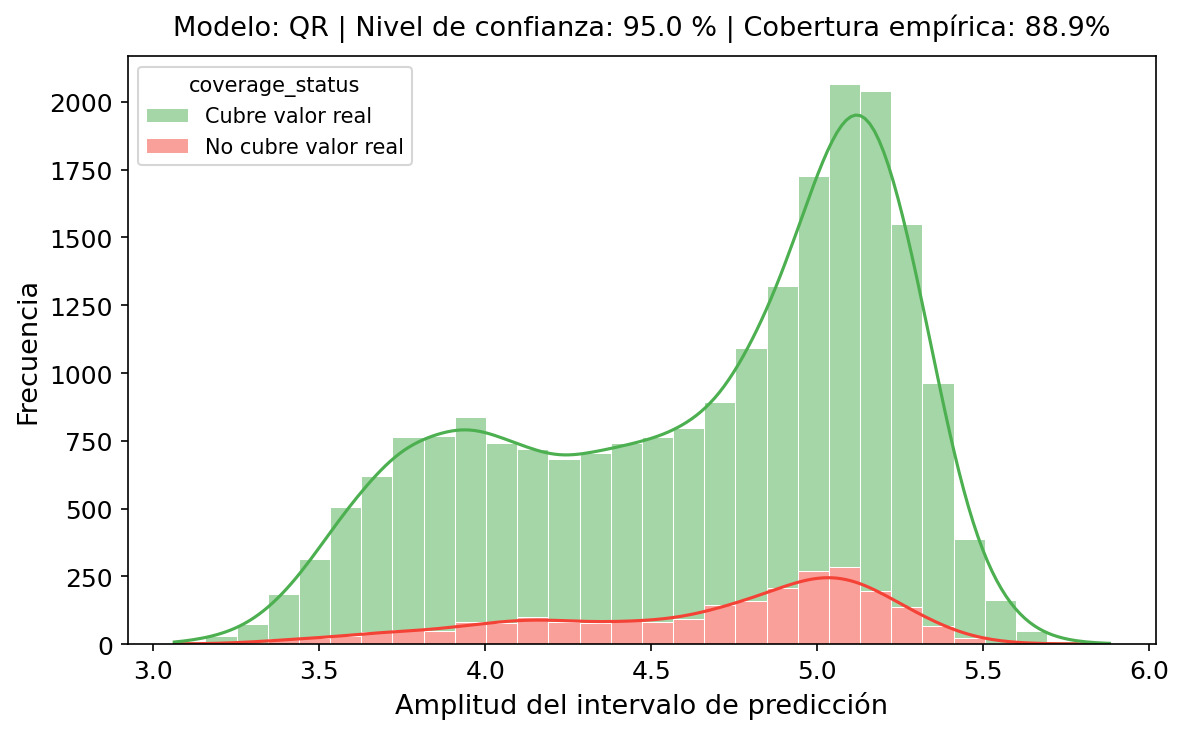

In [12]:
fig = plot_interval_width_histogram(df_AE_by_instance, pred_model_type='QR', confidence=0.95)
plt.show()

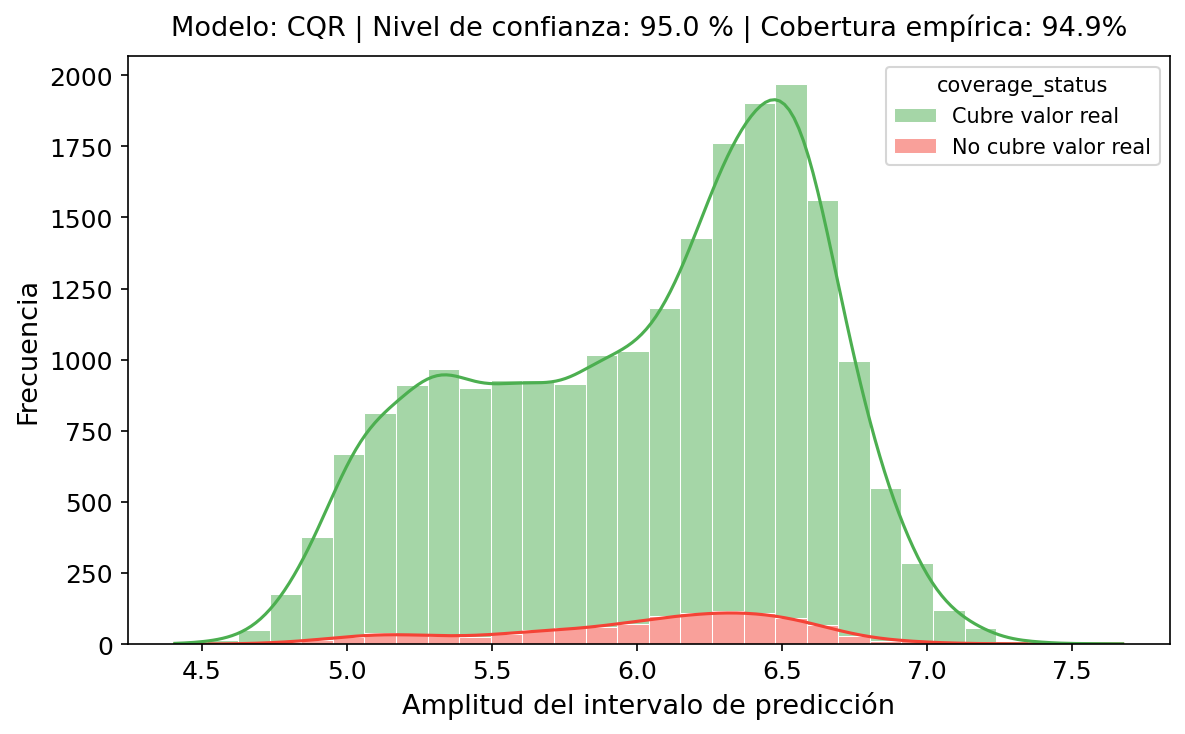

In [16]:
fig = plot_interval_width_histogram(df_AE_by_instance, pred_model_type='CQR', confidence=0.95)
plt.show()

### Tabla resumen de la cobertura por tamaño de intervalo para cada método

In [17]:
import matplotlib.ticker as mticker

def plot_coverage_by_interval(
    df: pd.DataFrame, 
    bin_width: float = 0.5,
    vmin=0.9, 
    vmax=1.0, 
    center=0.95, 
    figsize=(9,7), 
    dpi=150, 
    bins=None
) -> plt.Figure:
    
    sns.set(style="white")
    
    # Copia temporal y agrupar en franjas de bin_width
    df_temp = df.assign(
        interval_bin=lambda x: np.floor(x['pred_interval_width'] / bin_width) * bin_width
    )

    # Cobertura media y conteo
    coverage_matrix = df_temp.pivot_table(
        index='interval_bin',
        columns='pred_model_type',
        values='is_covered',
        aggfunc='mean'
    ).sort_index()

    count_matrix = df_temp.pivot_table(
        index='interval_bin',
        columns='pred_model_type',
        values='is_covered',
        aggfunc='count'
    ).sort_index()

    # Anotaciones
    annotations = coverage_matrix.mul(100).round(2).astype(str) + "\n(n=" + count_matrix.astype(str) + ")"

    # Crear figura
    plt.figure(figsize=figsize, dpi=dpi)
    ax = sns.heatmap(
        coverage_matrix,
        annot=annotations,
        fmt="",
        cmap="RdBu",
        center=center,
        vmin=vmin,
        vmax=vmax,
        cbar_kws={'label': 'Cobertura empírica (%)'},
        linecolor='#ededed',   # color de las líneas
        linewidths=0.5       # grosor de las líneas
    )

    # Colorbar con ticks cada 1%
    cbar = ax.collections[0].colorbar
    ticks = np.arange(vmin, vmax + 0.001, 0.01)
    cbar.set_ticks(ticks)
    cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%"))
    
    # Etiquetas de intervalos en el eje Y
    y_labels = [f"[{bin_val:.1f}, {bin_val + bin_width:.1f})" for bin_val in coverage_matrix.index]
    ax.set_yticklabels(y_labels, rotation=0)


    # Labels y título
    ax.set_xlabel("Método")
    ax.set_ylabel("Amplitud del intervalo")
    plt.tight_layout()
    return plt.gcf()

/tmp/ipykernel_11509/4087187778.py:22: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  coverage_matrix = df_temp.pivot_table(
/tmp/ipykernel_11509/4087187778.py:29: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  count_matrix = df_temp.pivot_table(


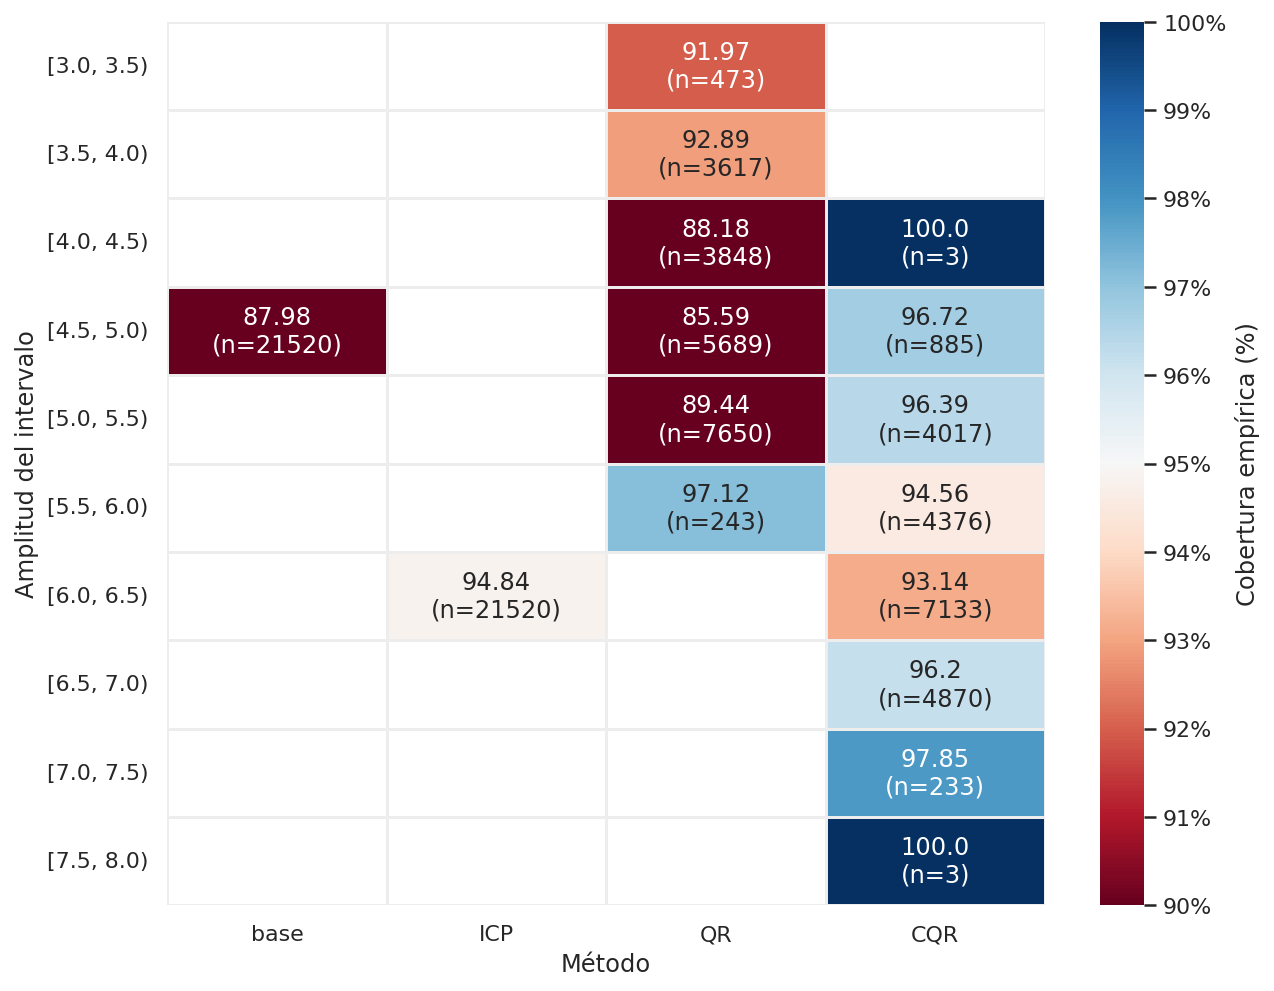

In [18]:
fig = plot_coverage_by_interval(df_AE_by_instance, bin_width=0.5, dpi=145)
plt.show()

### Tabla resumen de cobertura y amplitud media del intervalo por edad cronológica

In [19]:
# Agrupamos por método, confianza y edad truncada, calculando cobertura y ancho medio
df_AE_by_true_age = (
    df_AE_by_instance.assign(true_value_int=df_AE_by_instance['true_value'].astype(int))
    .groupby(['pred_model_type', 'confidence', 'true_value_int'])
    .agg(
        empirical_coverage=('is_covered', 'mean'),
        mean_interval_width=('pred_interval_width', 'mean')
    )
    .reset_index()
    .pivot(
        index='true_value_int',
        columns=['pred_model_type', 'confidence'],
        values=['empirical_coverage', 'mean_interval_width']
    )
)

# Multiplicar columnas de cobertura por 100
coverage_cols = [col for col in df_AE_by_true_age.columns if 'empirical_coverage' in str(col)]
df_AE_by_true_age[coverage_cols] = df_AE_by_true_age[coverage_cols] * 100

# Mostrar tabla con formato
styled_table = df_AE_by_true_age.style.format("{:.2f}")
show(styled_table, allow_html=True)

/tmp/ipykernel_11509/2770660001.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_model_type', 'confidence', 'true_value_int'])


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Gráfica de ...

In [20]:
# Agrupar por método, confianza y edad entera, calculando métricas
df_AE_coverage_by_age = (
    df_AE_by_instance.assign(true_value_int=df_AE_by_instance['true_value'].astype(int))
    .groupby(['pred_model_type', 'confidence', 'true_value_int'])
    .agg(
        mean_coverage=('is_covered', lambda x: round(x.mean() * 100, 2)),
        mean_interval_width=('pred_interval_width', lambda x: round(x.mean(), 2)),
        mean_interval_score=('interval_score', lambda x: round(x.mean(), 2)),
        count=('is_covered', 'count')
    )
    .reset_index()
)

/tmp/ipykernel_11509/1550930925.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_model_type', 'confidence', 'true_value_int'])


/tmp/ipykernel_11509/1335876678.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


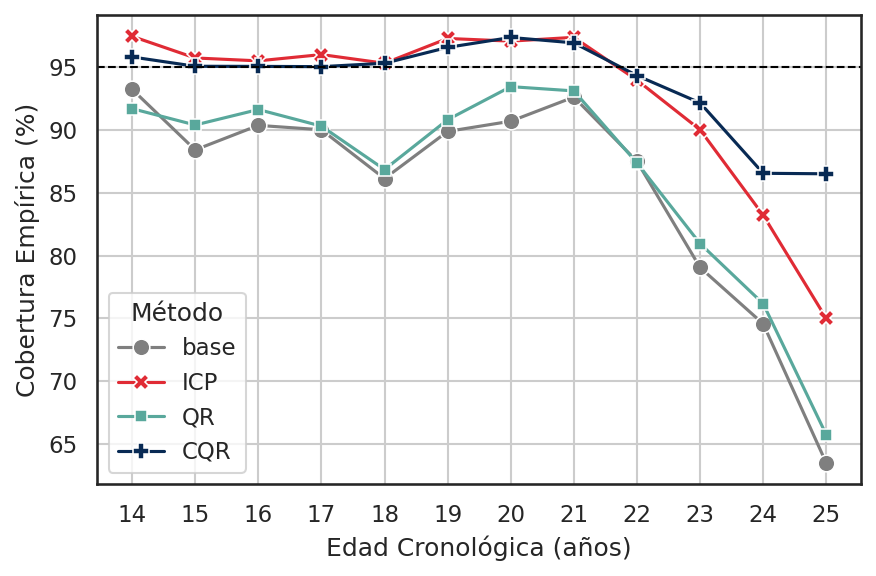

In [21]:
# Configuración de la figura
plt.figure(figsize=(6, 4), dpi=150)
color_dict = {'base': '#7f7f7f', 'ICP': '#e02b35', 'QR': '#59a89c', 'CQR': '#082a54'}

# Lineplot
lineplot = sns.lineplot(
    data=df_AE_coverage_by_age,
    x='true_value_int',
    y='mean_coverage',
    hue='pred_model_type',
    style='pred_model_type',
    markers=True,
    dashes=False,
    palette=color_dict,
    ci=None
)

# Ajuste del tamaño de los marcadores
plt.setp(lineplot.lines, markersize=8)

# Etiquetas y estilo
plt.xlabel('Edad Cronológica (años)')
plt.ylabel('Cobertura Empírica (%)')
plt.legend(title='Método')
plt.grid(True)

# Ticks del eje X por cada año
plt.xticks(range(df_AE_coverage_by_age['true_value_int'].min(),
                 df_AE_coverage_by_age['true_value_int'].max() + 1, 1))

# Línea de referencia para cobertura objetivo
plt.axhline(y=95, color='black', linestyle='--', linewidth=1.0, zorder=2)

plt.tight_layout()
plt.show()

/tmp/ipykernel_11509/2845307403.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


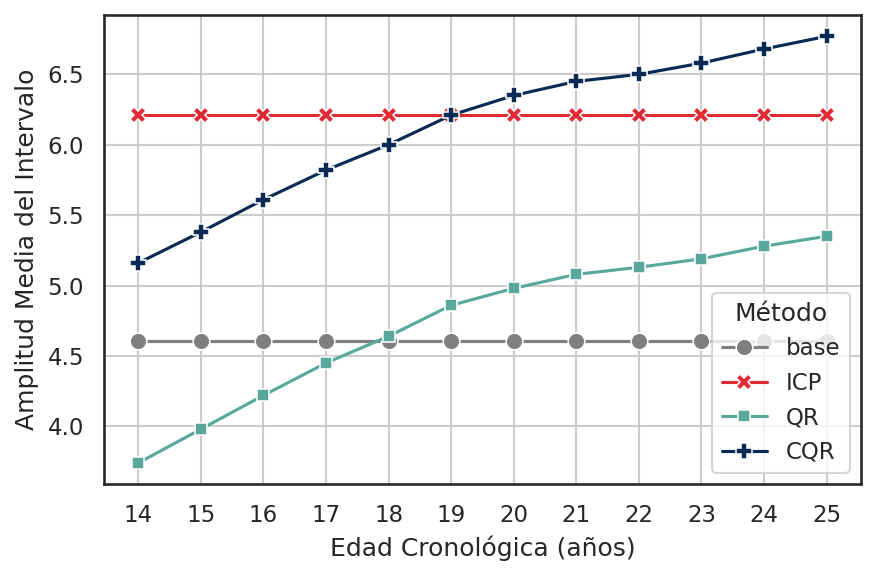

In [22]:
# Configuración de la figura
plt.figure(figsize=(6, 4), dpi=150)
color_dict = {'base': '#7f7f7f', 'ICP': '#e02b35', 'QR': '#59a89c', 'CQR': '#082a54'}

# Lineplot
lineplot = sns.lineplot(
    data=df_AE_coverage_by_age,
    x='true_value_int',
    y='mean_interval_width',
    hue='pred_model_type',
    style='pred_model_type',
    markers=True,
    dashes=False,
    palette=color_dict,
    ci=None
)

# Ajuste del tamaño de los marcadores
plt.setp(lineplot.lines, markersize=8)

# Etiquetas y estilo
plt.xlabel('Edad Cronológica (años)')
plt.ylabel('Amplitud Media del Intervalo')
plt.legend(title='Método')
plt.grid(True)

# Ticks del eje X por cada año
plt.xticks(range(df_AE_coverage_by_age['true_value_int'].min(),
                 df_AE_coverage_by_age['true_value_int'].max() + 1, 1))


plt.tight_layout()
plt.show()

## 1.6. Análisis de la cobertura en base al sexo

In [23]:
# # Pivotea para tener todas las métricas en columnas multi-nivel
# pivot_interval_metrics = df_AE_by_run[df_AE_by_run['sex']].pivot(
#     index='iteration',
#     columns=['pred_model_type', 'confidence'],
#     values=['empirical_coverage', 'mean_interval_width', 'mean_interval_score'] 
# )

# # Reorganiza niveles para que las métricas estén en el nivel superior
# pivot_interval_metrics = pivot_interval_metrics.swaplevel(axis=1).sort_index(axis=1)

# # Define el orden deseado de las métricas
# metric_order = ['empirical_coverage', 'mean_interval_width', 'mean_interval_score'] 

# # Reindexa las columnas según el orden especificado
# pivot_interval_metrics = pivot_interval_metrics.reindex(columns=metric_order, level=0)

# # Calcular la media por método para cada métrica
# pivot_with_mean = pd.concat([
#     pivot_interval_metrics,
#     pivot_interval_metrics.mean().to_frame().T.rename(index={0: 'Media'})
# ])

# # Multiplicar columnas de cobertura por 100
# coverage_cols = [col for col in pivot_with_mean.columns if 'empirical_coverage' in str(col)]
# pivot_with_mean[coverage_cols] = pivot_with_mean[coverage_cols] * 100

# # Mostrar tabla con formato
# styled_table = pivot_with_mean.style.format("{:.2f}")
# show(styled_table, allow_html=True)

## 1.7. Otras pruebas

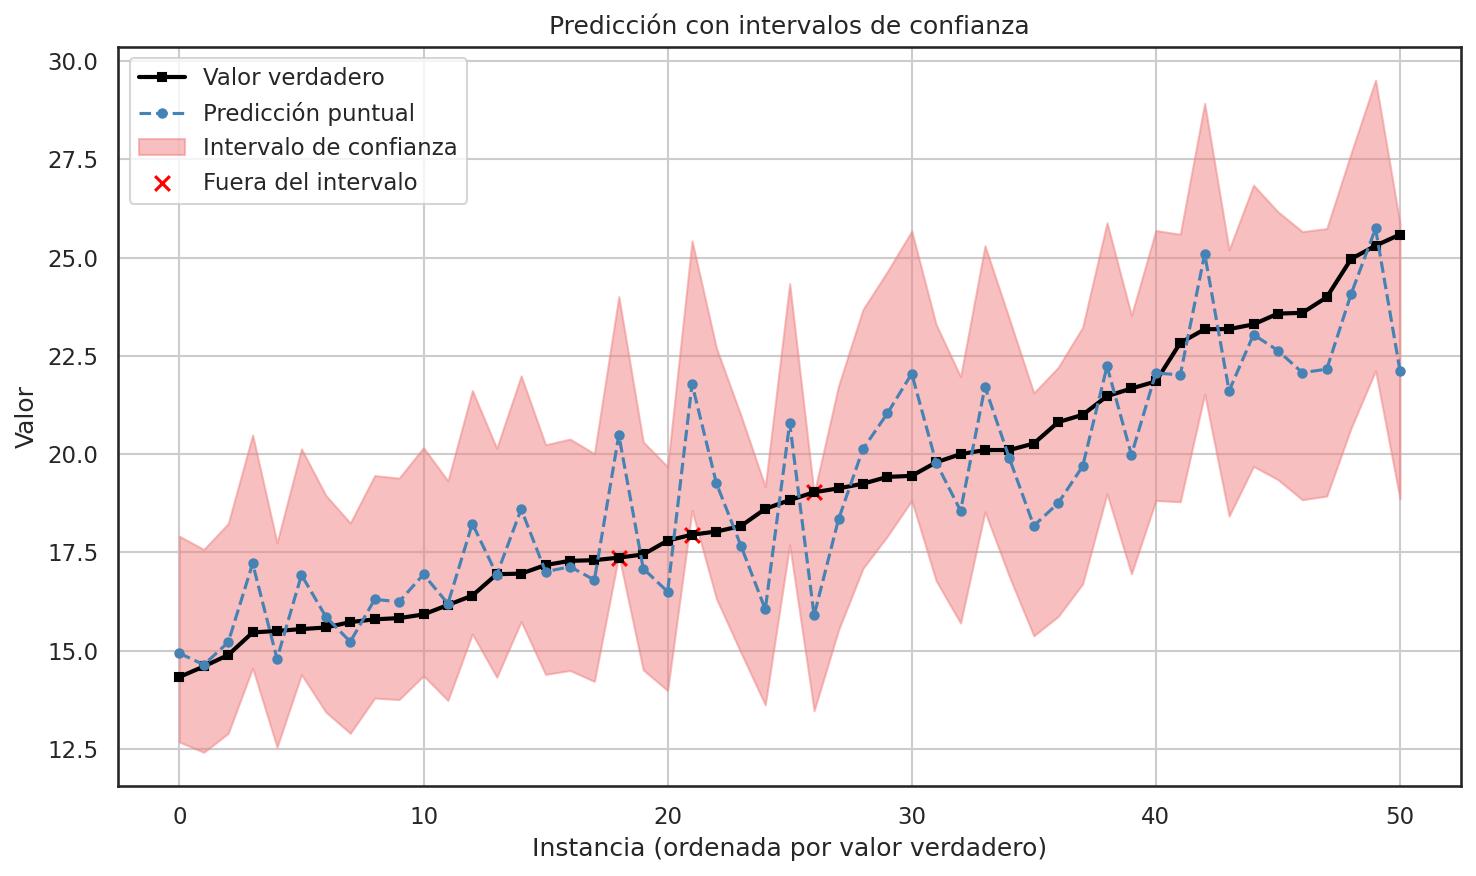

In [24]:
df_AE_by_instance_misclassified_CQR = (df_AE_by_instance[(df_AE_by_instance['pred_model_type'] == 'CQR')])

n = 51

# Extraer los valores y convertir a tensores
pred_point_values = df_AE_by_instance_misclassified_CQR['pred_point_value'].values[0:n]
pred_lower_bound = df_AE_by_instance_misclassified_CQR['pred_lower_bound'].values[0:n]
pred_upper_bound = df_AE_by_instance_misclassified_CQR['pred_upper_bound'].values[0:n]
true_values = df_AE_by_instance_misclassified_CQR['true_value'].values[0:n]

# Llamar a la función de plot
plot_interval_predictions(
    pred_point_values=pred_point_values,
    pred_lower_bound=pred_lower_bound,
    pred_upper_bound=pred_upper_bound,
    true_values=true_values
)

# PROBLEMA 2: CLASIFICACIÓN DE MAYORÍA DE EDAD

## 2.1. Carga de resultados y obtención de métricas

In [25]:
# Carga de datos
df_AMC_by_instance = pd.read_csv('results/02_AMC_maxillofacial_test_results.csv')

# Nueva columna: verdaderos positivos
df_AMC_by_instance['TP'] = (df_AMC_by_instance['pred_class'] == 1) & (df_AMC_by_instance['true_class'] == 1)

# Nueva columna: verdaderos negativos
df_AMC_by_instance['TN'] = (df_AMC_by_instance['pred_class'] == 0) & (df_AMC_by_instance['true_class'] == 0)

# falsos positivos
df_AMC_by_instance['FP'] = (df_AMC_by_instance['pred_class'] == 1) & (df_AMC_by_instance['true_class'] == 0)

# Nueva columna: falsos negativos
df_AMC_by_instance['FN'] = (df_AMC_by_instance['pred_class'] == 0) & (df_AMC_by_instance['true_class'] == 1)

# Nueva columna: cobertura (true/false)
df_AMC_by_instance['is_covered'] = ((df_AMC_by_instance['true_class'] == 0) & (df_AMC_by_instance['pred_set_under_18'] == 1)) | \
                          ((df_AMC_by_instance['true_class'] == 1) & (df_AMC_by_instance['pred_set_over_18'] == 1))
                          
# Nueva columna: tamaño del conjunto de predicción
df_AMC_by_instance['pred_set_size'] = df_AMC_by_instance['pred_set_under_18'] + df_AMC_by_instance['pred_set_over_18']

# Nueva columna: set score
alpha = 1 - df_AMC_by_instance['confidence']
df_AMC_by_instance['set_score'] = df_AMC_by_instance['pred_set_size'] + 1/alpha * (~df_AMC_by_instance['is_covered'])

# Ordenar por iteración y por tipo de predicción
custom_order = ['base', 'LAC', 'MCM']
df_AMC_by_instance = sort_by_column(df_AMC_by_instance, 'pred_model_type', custom_order, 
                                      secondary_column='iteration')

display(df_AMC_by_instance)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [26]:
# Agrupar y calcular métricas
df_AMC_by_run = (
    df_AMC_by_instance
    .groupby(['pred_model_type', 'confidence', 'iteration'])
    .apply(lambda g: pd.Series({
        'accuracy': (g['TP'].sum() + g['TN'].sum()) / len(g),
        'sensitivity': g['TP'].sum() / (g['TP'].sum() + g['FN'].sum()),
        'specifity': g['TN'].sum() / (g['TN'].sum() + g['FP'].sum()),
        'empirical_coverage': g['is_covered'].mean(),
        'mean_set_size': g['pred_set_size'].mean(),
        'mean_set_score': g['set_score'].mean()
    }))
    .reset_index()
)

# Ordenar por iteración y por tipo de predicción
custom_order = ['base', 'LAC', 'MCM']
df_AMC_by_run = sort_by_column(df_AMC_by_run, 'pred_model_type', custom_order, secondary_column='iteration')

display(df_AMC_by_run)

/tmp/ipykernel_11509/2101736352.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_model_type', 'confidence', 'iteration'])
/tmp/ipykernel_11509/2101736352.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## 2.2. Análisis de las métricas para la clasificación puntual de mayoría de edad

### Tabla resumen por método y ejecución

In [27]:
# Pivota para tener todas las métricas en columnas multi-nivel
pivot_point_metrics = df_AMC_by_run.pivot(
    index='iteration',
    columns=['pred_model_type', 'confidence'],
    values=['accuracy', 'sensitivity', 'specifity'] 
)

# Reorganiza niveles para que las métricas estén en el nivel superior
pivot_point_metrics = pivot_point_metrics.swaplevel(axis=1).sort_index(axis=1)

# Multiplica todos los valores por 100
pivot_point_metrics_100 = pivot_point_metrics * 100

# Calcular la media por método para cada métrica
pivot_point_with_mean = pd.concat([
    pivot_point_metrics_100,
    pivot_point_metrics_100.mean().to_frame().T.rename(index={0: 'Media'}),
    pivot_point_metrics_100.std().to_frame().T.rename(index={0: 'STD'})
])

# Muestra con 2 decimales tanto MAE como MSE
styled_table = pivot_point_with_mean.style.format("{:.2f}")
show(styled_table, allow_html=True)


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Análisis de la varianza

In [28]:
# Ejemplo de uso:
for metric in ['accuracy', 'sensitivity', 'specifity']:
    run_group_comparison(df_AMC_by_run, metric)


ANÁLISIS ESTADÍSTICO PARA: ACCURACY
• Normalidad (Shapiro-Wilk): p = 0.0798 ✅
• Homocedasticidad (Levene): p = 0.5908 ✅

📊 ANOVA clásico + Tukey HSD


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



🔎 Comparaciones por pares (Tukey HSD):


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



ANÁLISIS ESTADÍSTICO PARA: SENSITIVITY
• Normalidad (Shapiro-Wilk): p = 0.3340 ✅
• Homocedasticidad (Levene): p = 0.9993 ✅

📊 ANOVA clásico + Tukey HSD


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



ANÁLISIS ESTADÍSTICO PARA: SPECIFITY
• Normalidad (Shapiro-Wilk): p = 0.0718 ✅
• Homocedasticidad (Levene): p = 0.8098 ✅

📊 ANOVA clásico + Tukey HSD


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## 2.3. Análisis de las métricas para la clasificación de mayoría de edad en conjunto de predicción 


### Tabla resumen por método y ejecución

In [29]:
# Pivotea para tener todas las métricas en columnas multi-nivel
pivot_interval_metrics = df_AMC_by_run.pivot(
    index='iteration',
    columns=['pred_model_type', 'confidence'],
    values=['empirical_coverage', 'mean_set_size', 'mean_set_score'] 
)

# Reorganiza niveles para que las métricas estén en el nivel superior
pivot_interval_metrics = pivot_interval_metrics.swaplevel(axis=1).sort_index(axis=1)

In [30]:
# Define el orden deseado de las métricas
metric_order = ['empirical_coverage', 'mean_set_size', 'mean_set_score'] 

# Reindexa las columnas según el orden especificado
pivot_interval_metrics = pivot_interval_metrics.reindex(columns=metric_order, level=0)

In [31]:
# Calcular la media por método para cada métrica
pivot_with_mean = pd.concat([
    pivot_interval_metrics,
    pivot_interval_metrics.mean().to_frame().T.rename(index={0: 'Media'}),
    pivot_interval_metrics.std().to_frame().T.rename(index={0: 'STD'})
])

# Multiplicar columnas de cobertura por 100
coverage_cols = [col for col in pivot_with_mean.columns if 'empirical_coverage' in str(col)]
pivot_with_mean[coverage_cols] = pivot_with_mean[coverage_cols] * 100

# Mostrar tabla con formato
styled_table = pivot_with_mean.style.format("{:.2f}")
show(styled_table, allow_html=True)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Análisis de la varianza

In [34]:
# Ejemplo de uso:
for metric in ['empirical_coverage', 'mean_set_size']:
    run_group_comparison(df_AMC_by_run, metric)


ANÁLISIS ESTADÍSTICO PARA: EMPIRICAL_COVERAGE
• Normalidad (Shapiro-Wilk): p = 0.5033 ✅
• Homocedasticidad (Levene): p = 0.1883 ✅

📊 ANOVA clásico + Tukey HSD


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



🔎 Comparaciones por pares (Tukey HSD):


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



ANÁLISIS ESTADÍSTICO PARA: MEAN_SET_SIZE
• Normalidad (Shapiro-Wilk): p = 0.0068 ❌
• Homocedasticidad (Levene): p = 0.0031 ❌

📊 Kruskal-Wallis + Dunn


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



🔎 Comparaciones por pares (Dunn con Bonferroni):


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Gráfica de dispersión Cobertura empírica - Amplitud media del intervalo

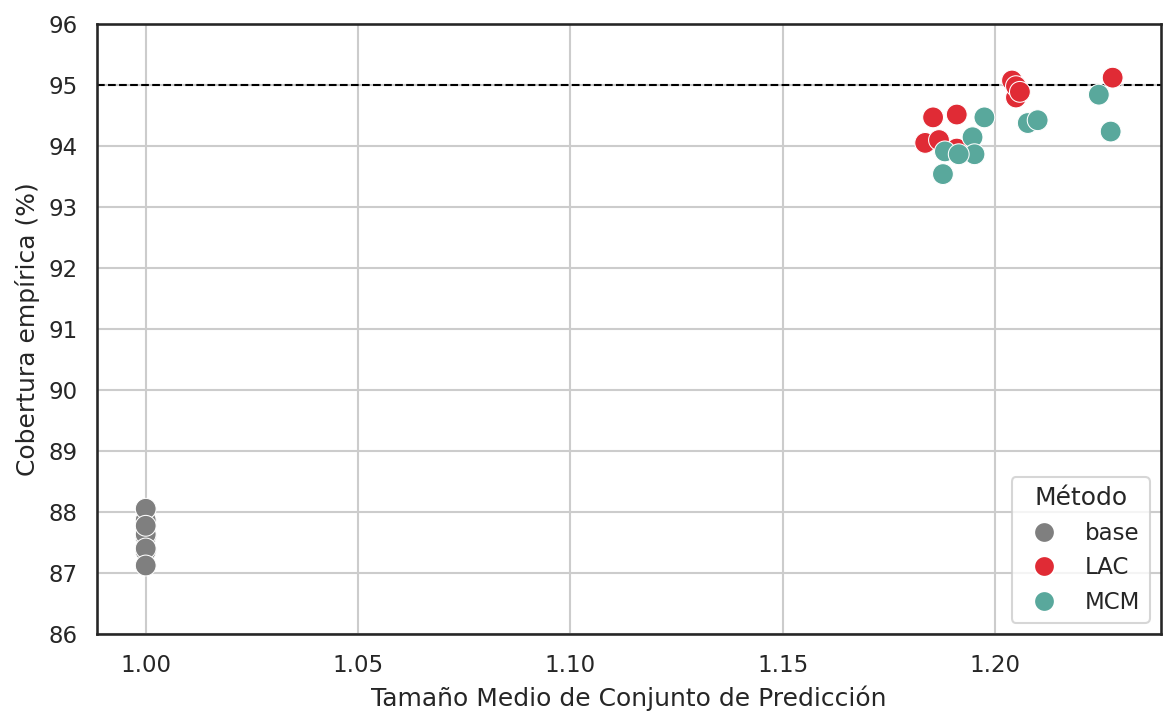

In [42]:
# Mapear colores
color_dict = {'base': '#7f7f7f', 'LAC': '#e02b35', 'MCM': '#59a89c'}
df_AMC_by_run_to_plot = df_AMC_by_run.copy()
df_AMC_by_run_to_plot['color'] = df_AMC_by_run_to_plot['pred_model_type'].map(color_dict)

#
plot_coverage_vs_set_size(
    mean_set_sizes=df_AMC_by_run_to_plot['mean_set_size'],
    empirical_coverages=df_AMC_by_run_to_plot['empirical_coverage'],
    model_types=df_AMC_by_run_to_plot['pred_model_type'],
    colors=df_AMC_by_run_to_plot['color'],
    confidence_level=0.95,
    figsize=(8, 5),
    dpi=150
)

## 2.4. Análisis de la cobertura en base a la clase

### Matriz de confusión conformal

In [43]:
def pred_set_label(row):
    if row['pred_set_under_18'] == 1 and row['pred_set_over_18'] == 0:
        return '{<18}'
    elif row['pred_set_under_18'] == 0 and row['pred_set_over_18'] == 1:
        return '{>=18}'
    elif row['pred_set_under_18'] == 1 and row['pred_set_over_18'] == 1:
        return '{<18,>=18}'
    else:
        return '∅'  # Por si acaso, aunque dices que nunca ocurre

df_AMC_by_instance['pred_set_label'] = df_AMC_by_instance.apply(pred_set_label, axis=1)

confusion_conformal = (
    df_AMC_by_instance
    .groupby(['pred_model_type', 'confidence', 'true_class', 'pred_set_label'])
    .size()
    .reset_index(name='count')
)

empirical_coverage_by_group = (
    df_AMC_by_instance
    .groupby(['pred_model_type', 'confidence'])['is_covered']
    .mean()
    .reset_index(name='empirical_coverage')
)

coverage_dict = {
    (row['pred_model_type'], row['confidence']): row['empirical_coverage']
    for _, row in empirical_coverage_by_group.iterrows()
}

# Posibles etiquetas de columnas en orden
pred_set_labels = ['{<18}', '{>=18}', '{<18,>=18}']

/tmp/ipykernel_11509/1370397145.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_model_type', 'confidence', 'true_class', 'pred_set_label'])
/tmp/ipykernel_11509/1370397145.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_model_type', 'confidence'])['is_covered']


/tmp/ipykernel_11509/2997470824.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (model, conf), group in confusion_conformal.groupby(['pred_model_type', 'confidence']):


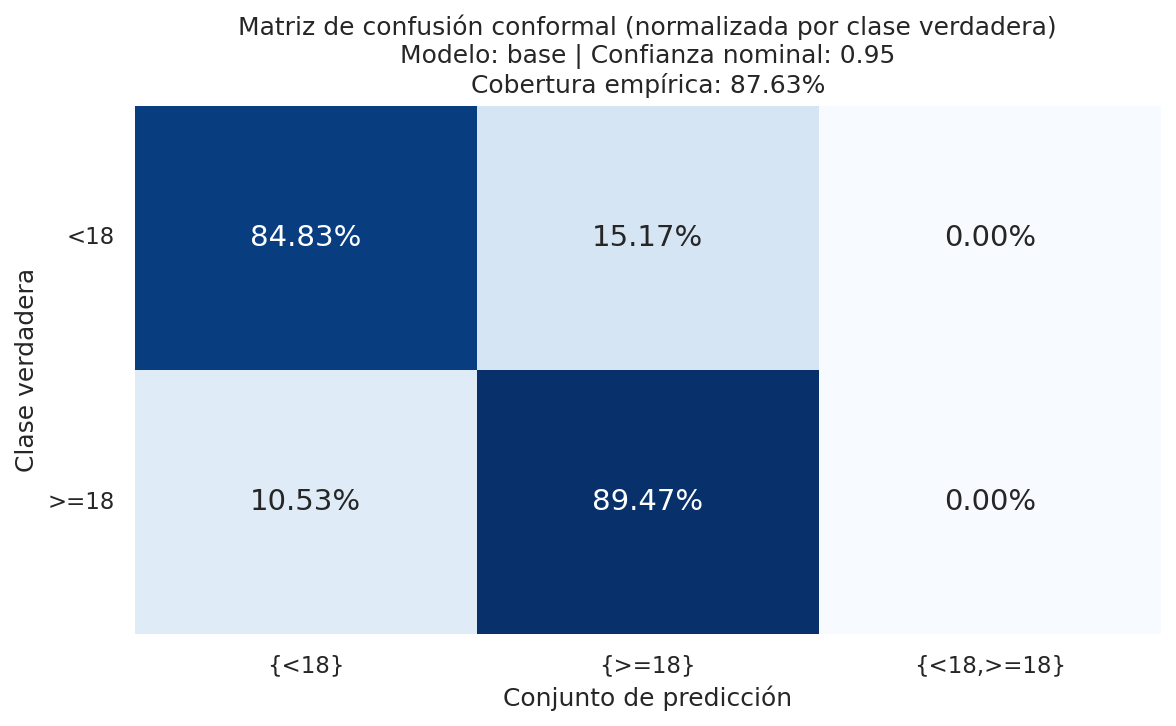

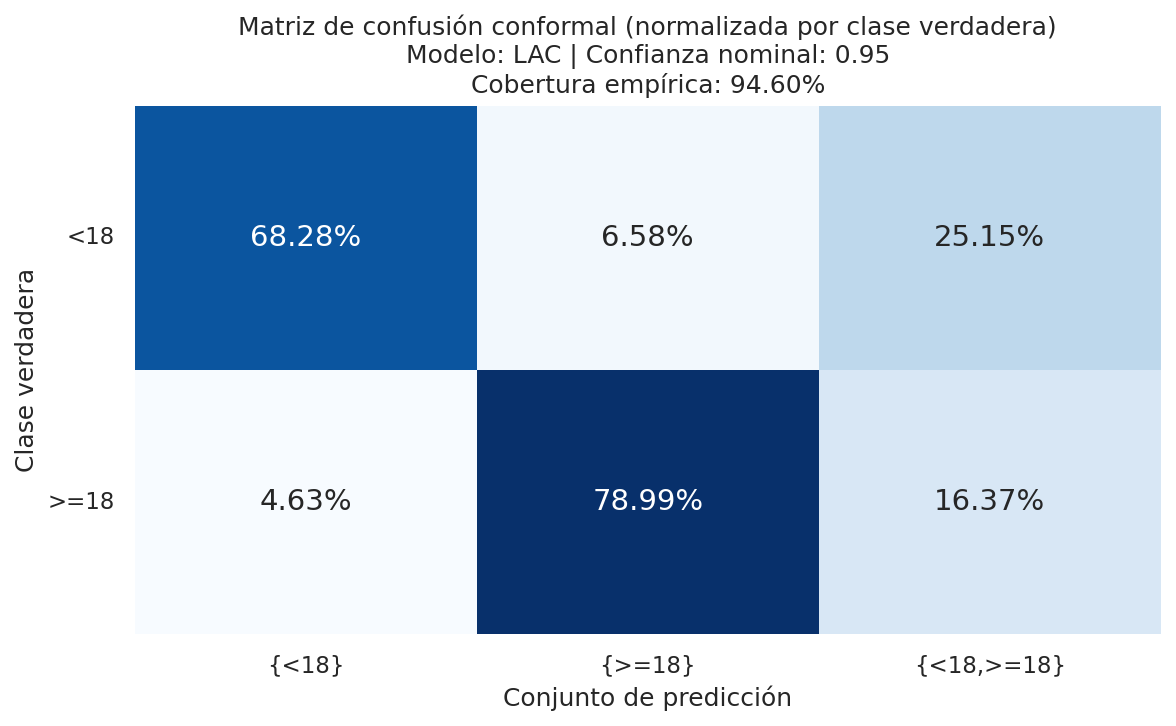

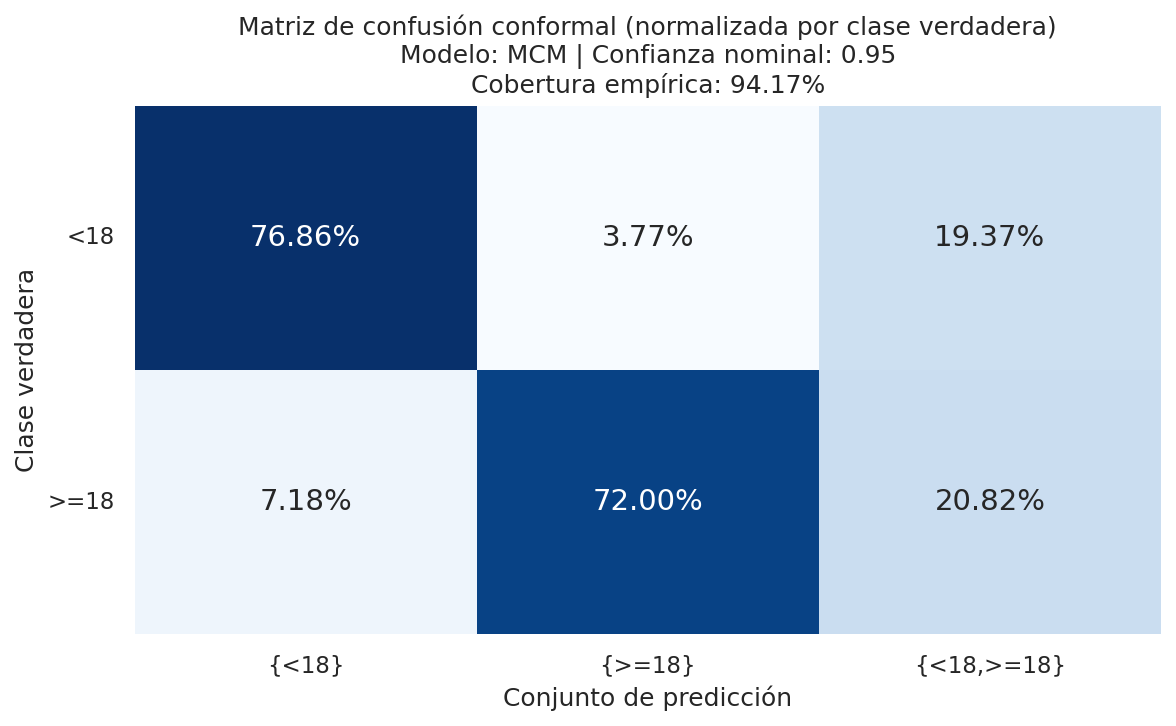

In [44]:
# Dibujar una matriz por cada combinación
for (model, conf), group in confusion_conformal.groupby(['pred_model_type', 'confidence']):
    # Crear tabla cruzada (confusion matrix)
    pivot = group.pivot(index='true_class', columns='pred_set_label', values='count').fillna(0)

    # Asegurar columnas en orden
    for label in pred_set_labels:
        if label not in pivot.columns:
            pivot[label] = 0
    pivot = pivot[pred_set_labels]

    # Normalizar por clase verdadera (por fila)
    pivot = pivot.div(pivot.sum(axis=1), axis=0).fillna(0)
    # pivot = pivot.div(pivot.sum(axis=0), axis=1).fillna(0)

    # Obtener cobertura
    coverage = coverage_dict.get((model, conf), None)
    coverage_str = f'{coverage:.2%}' if coverage is not None else 'N/A'

    # Plot
    plt.figure(figsize=(8, 5), dpi=150)
    # sns.heatmap(pivot, annot=True, fmt='.2%', cmap='Blues', cbar=False, annot_kws={"size": 14})
    sns.heatmap(pivot, annot=True, fmt='.2%',cmap='Blues', cbar=False, annot_kws={"size": 14})
    plt.title(f'Matriz de confusión conformal (normalizada por clase verdadera)\nModelo: {model} | Confianza nominal: {conf}\n' +
              f'Cobertura empírica: {coverage_str}')
    plt.xlabel('Conjunto de predicción', fontsize=12)
    plt.ylabel('Clase verdadera', fontsize=12)
    plt.yticks([0.5, 1.5], ['<18', '>=18'], rotation=0)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


# PROBLEMA 3: ESTIMACIÓN DE EDAD COMO PROBLEMA DE CLASIFICACIÓN

## 3.1. Carga de datos

In [72]:
# Carga de datos
df_AGC_by_instance = pd.read_csv('results/03_AC_maxillofacial_test_results.csv')

# Nueva columna: cobertura (true/false)
df_AGC_by_instance['well_classified'] = (df_AGC_by_instance['true_class'] == df_AGC_by_instance['pred_class'])

# Nueva columna: cobertura (true/false) 
df_AGC_by_instance['is_covered'] = (
    ((df_AGC_by_instance['true_class'] ==  0) & (df_AGC_by_instance['pred_set_14'] == 1)) |
    ((df_AGC_by_instance['true_class'] ==  1) & (df_AGC_by_instance['pred_set_15'] == 1)) |
    ((df_AGC_by_instance['true_class'] ==  2) & (df_AGC_by_instance['pred_set_16'] == 1)) |
    ((df_AGC_by_instance['true_class'] ==  3) & (df_AGC_by_instance['pred_set_17'] == 1)) |
    ((df_AGC_by_instance['true_class'] ==  4) & (df_AGC_by_instance['pred_set_18'] == 1)) |
    ((df_AGC_by_instance['true_class'] ==  5) & (df_AGC_by_instance['pred_set_19'] == 1)) |
    ((df_AGC_by_instance['true_class'] ==  6) & (df_AGC_by_instance['pred_set_20'] == 1)) |
    ((df_AGC_by_instance['true_class'] ==  7) & (df_AGC_by_instance['pred_set_21'] == 1)) |
    ((df_AGC_by_instance['true_class'] ==  8) & (df_AGC_by_instance['pred_set_22'] == 1)) |
    ((df_AGC_by_instance['true_class'] ==  9) & (df_AGC_by_instance['pred_set_23'] == 1)) |
    ((df_AGC_by_instance['true_class'] == 10) & (df_AGC_by_instance['pred_set_24'] == 1)) |
    ((df_AGC_by_instance['true_class'] == 11) & (df_AGC_by_instance['pred_set_25'] == 1)) |
    ((df_AGC_by_instance['true_class'] == 12) & (df_AGC_by_instance['pred_set_26'] == 1))
)

# Nueva columna: tamaño del conjunto de predicción
df_AGC_by_instance['pred_set_size'] = (
    df_AGC_by_instance['pred_set_14'] + df_AGC_by_instance['pred_set_15'] + 
    df_AGC_by_instance['pred_set_16'] + df_AGC_by_instance['pred_set_17'] + 
    df_AGC_by_instance['pred_set_18'] + df_AGC_by_instance['pred_set_19'] + 
    df_AGC_by_instance['pred_set_20'] + df_AGC_by_instance['pred_set_21'] + 
    df_AGC_by_instance['pred_set_22'] + df_AGC_by_instance['pred_set_23'] + 
    df_AGC_by_instance['pred_set_24'] + df_AGC_by_instance['pred_set_25'] + 
    df_AGC_by_instance['pred_set_26'] 
)

# Nueva columna: set score
alpha = 1 - df_AGC_by_instance['confidence']
df_AGC_by_instance['set_score'] = (df_AGC_by_instance['pred_set_size'] +
                                    1/alpha * (~df_AGC_by_instance['is_covered']))

# Nueva columna: error absoluto medio
df_AGC_by_instance['absolute_error'] = (
    df_AGC_by_instance['true_class'] - df_AGC_by_instance['pred_class']
).abs()

# Ordenar por iteración y por tipo de predicción
custom_order = ['base', 'LAC', 'MCM', 'APS', 'RAPS', 'SAPS']
df_AGC_by_intance = sort_by_column(df_AGC_by_instance, 'pred_model_type', custom_order, 
                                    secondary_column='iteration')

display(df_AGC_by_instance)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [73]:
# Agrupar y calcular métricas
df_AGC_by_run = (
    df_AGC_by_instance
    .groupby(['pred_model_type', 'confidence', 'iteration'])
    .apply(lambda g: pd.Series({
        'accuracy': g['well_classified'].mean(),
        'empirical_coverage': g['is_covered'].mean(),
        'mean_set_size': g['pred_set_size'].mean(),
        'mean_set_score': g['set_score'].mean(),
        'mean_absolute_error': g['absolute_error'].mean()
    }))
    .reset_index()
)

display(df_AGC_by_run)

/tmp/ipykernel_11509/4235270819.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_model_type', 'confidence', 'iteration'])
/tmp/ipykernel_11509/4235270819.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## 3.2. Análisis de las métricas para la clasificación puntual 

In [74]:
# Pivota para tener todas las métricas en columnas multi-nivel
pivot_point_metrics = df_AGC_by_run.pivot(
    index='iteration',
    columns=['pred_model_type', 'confidence'],
    values=['mean_absolute_error'] 
)

# Reorganiza niveles para que las métricas estén en el nivel superior
pivot_point_metrics = pivot_point_metrics.swaplevel(axis=1).sort_index(axis=1)

# Calcular la media por método para cada métrica
pivot_point_with_mean = pd.concat([
    pivot_point_metrics,
    pivot_point_metrics.mean().to_frame().T.rename(index={0: 'Media'})
])

# Muestra con 2 decimales tanto MAE como MSE
styled_table = pivot_point_with_mean.style.format("{:.2f}")
show(styled_table, allow_html=True)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Análisis de consecutividad

In [75]:
# Agrupar columnas del set de predicción
pred_cols = [f"pred_set_{age}" for age in range(14, 27)]

# Matriz original con solo las columnas pred_set
X = df_AGC_by_instance[pred_cols].to_numpy()

# Añadir columna de ceros al inicio y al final
X_ext = np.c_[np.zeros((X.shape[0], 1), dtype=int), X, np.zeros((X.shape[0], 1), dtype=int)]

# Calcular diferencias fila a fila
diffs = np.diff(X_ext, axis=1)

# Contar inicios y finales de bloque en cada fila
num_inicios = (diffs == 1).sum(axis=1)
num_finales = (diffs == -1).sum(axis=1)

# Un único bloque de 1s si hay exactamente 1 inicio y 1 final
df_AGC_by_instance["all_consecutive"] = (num_inicios == 1) & (num_finales == 1)

display(df_AGC_by_instance)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [76]:
# Agrupar y calcular métricas
df_AGC_by_run_consecutivity = (
    df_AGC_by_instance
    .groupby(['pred_model_type', 'confidence', 'iteration'])
    .apply(lambda g: pd.Series({
        'mean_consecutive_pred_set': g['all_consecutive'].mean()
    }))
    .reset_index()
)

display(df_AGC_by_run_consecutivity)

/tmp/ipykernel_11509/2532365526.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_model_type', 'confidence', 'iteration'])
/tmp/ipykernel_11509/2532365526.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [77]:
# Pivota para tener todas las métricas en columnas multi-nivel
pivot_point_metrics_consecutivity= df_AGC_by_run_consecutivity.pivot(
    index='iteration',
    columns=['pred_model_type', 'confidence'],
    values=['mean_consecutive_pred_set'] 
)

# Reorganiza niveles para que las métricas estén en el nivel superior
pivot_point_metrics_consecutivity = pivot_point_metrics_consecutivity.swaplevel(axis=1).sort_index(axis=1)

# Calcular la media por método para cada métrica
pivot_point_with_mean = pd.concat([
    pivot_point_metrics_consecutivity,
    pivot_point_metrics_consecutivity.mean().to_frame().T.rename(index={0: 'Media'})
])

# Muestra con 2 decimales tanto MAE como MSE
styled_table = pivot_point_with_mean.style.format("{:.2f}")
show(styled_table, allow_html=True)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## 3.3.  

### Tabla resumen por método y ejecución

In [78]:
# Pivotea para tener todas las métricas en columnas multi-nivel
pivot_interval_metrics = df_AGC_by_run.pivot(
    index='iteration',
    columns=['pred_model_type', 'confidence'],
    values=['empirical_coverage', 'mean_set_size', 'mean_set_score'] 
)

# Reorganiza niveles para que las métricas estén en el nivel superior
pivot_interval_metrics = pivot_interval_metrics.swaplevel(axis=1).sort_index(axis=1)

In [79]:
# Define el orden deseado de las métricas
metric_order = ['empirical_coverage', 'mean_set_size', 'mean_set_score'] 

# Reindexa las columnas según el orden especificado
pivot_interval_metrics = pivot_interval_metrics.reindex(columns=metric_order, level=0)

In [80]:
# Calcular la media por método para cada métrica
pivot_with_mean = pd.concat([
    pivot_interval_metrics,
    pivot_interval_metrics.mean().to_frame().T.rename(index={0: 'Media'})
])

# Multiplicar columnas de cobertura por 100
coverage_cols = [col for col in pivot_with_mean.columns if 'empirical_coverage' in str(col)]
pivot_with_mean[coverage_cols] = pivot_with_mean[coverage_cols] * 100

# Mostrar tabla con formato
styled_table = pivot_with_mean.style.format("{:.2f}")
show(styled_table, allow_html=True)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Análisis de varianza

In [81]:

df_AGC_by_run_for_stat_com = df_AGC_by_run[df_AGC_by_run['pred_model_type']!='base']
df_AGC_by_run_for_stat_com = df_AGC_by_run_for_stat_com[df_AGC_by_run_for_stat_com['pred_model_type']!='MCM']

for metric in ['empirical_coverage', 'mean_set_size', 'mean_set_score']:
    run_group_comparison(df_AGC_by_run_for_stat_com, metric)


ANÁLISIS ESTADÍSTICO PARA: EMPIRICAL_COVERAGE
• Normalidad (Shapiro-Wilk): p = 0.5681 ✅
• Homocedasticidad (Levene): p = 0.9022 ✅

📊 ANOVA clásico + Tukey HSD


/mnt/homeGPU/dgonzalez/conda_envs/envs/pytorch_env/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



🔎 Comparaciones por pares (Tukey HSD):


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



ANÁLISIS ESTADÍSTICO PARA: MEAN_SET_SIZE
• Normalidad (Shapiro-Wilk): p = 0.3962 ✅
• Homocedasticidad (Levene): p = 0.9393 ✅

📊 ANOVA clásico + Tukey HSD


/mnt/homeGPU/dgonzalez/conda_envs/envs/pytorch_env/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



🔎 Comparaciones por pares (Tukey HSD):


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



ANÁLISIS ESTADÍSTICO PARA: MEAN_SET_SCORE
• Normalidad (Shapiro-Wilk): p = 0.0049 ❌
• Homocedasticidad (Levene): p = 0.8793 ✅

📊 Kruskal-Wallis + Dunn


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



🔎 Comparaciones por pares (Dunn con Bonferroni):


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Gráfica de dispersión Cobertura empírica - Tamaño medio del conjunto

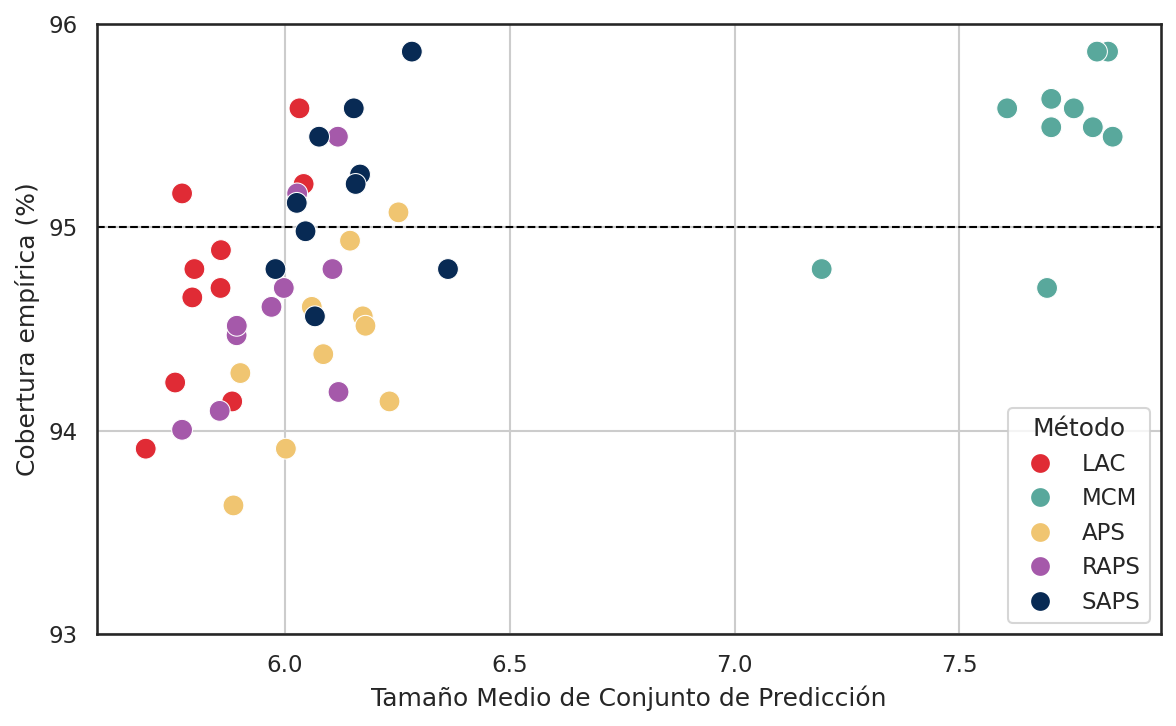

In [82]:
# Mapear colores
color_dict = {'base': '#7f7f7f', 'LAC': '#e02b35', 'MCM': '#59a89c', 
              'APS': '#f0c571', 'RAPS': '#a559aa', 'SAPS': '#082a54'}
df_AGC_by_run_to_plot = df_AGC_by_run[df_AGC_by_run['pred_model_type']!='base'].copy()
# df_AGC_by_run_to_plot = df_AGC_by_run_to_plot[df_AGC_by_run_to_plot['pred_model_type'] != 'MCM']
df_AGC_by_run_to_plot['color'] = df_AGC_by_run_to_plot['pred_model_type'].map(color_dict)

#
plot_coverage_vs_set_size(
    mean_set_sizes=df_AGC_by_run_to_plot['mean_set_size'],
    empirical_coverages=df_AGC_by_run_to_plot['empirical_coverage'],
    model_types=df_AGC_by_run_to_plot['pred_model_type'],
    colors=df_AGC_by_run_to_plot['color'],
    confidence_level=0.95,
    figsize=(8, 5),
    dpi=150
)

## 3.4. Análisis de la cobertura por tamaño del conjunto de predicción

/tmp/ipykernel_11509/2628174590.py:85: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  coverage_matrix = df.pivot_table(
/tmp/ipykernel_11509/2628174590.py:92: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  count_matrix = df.pivot_table(


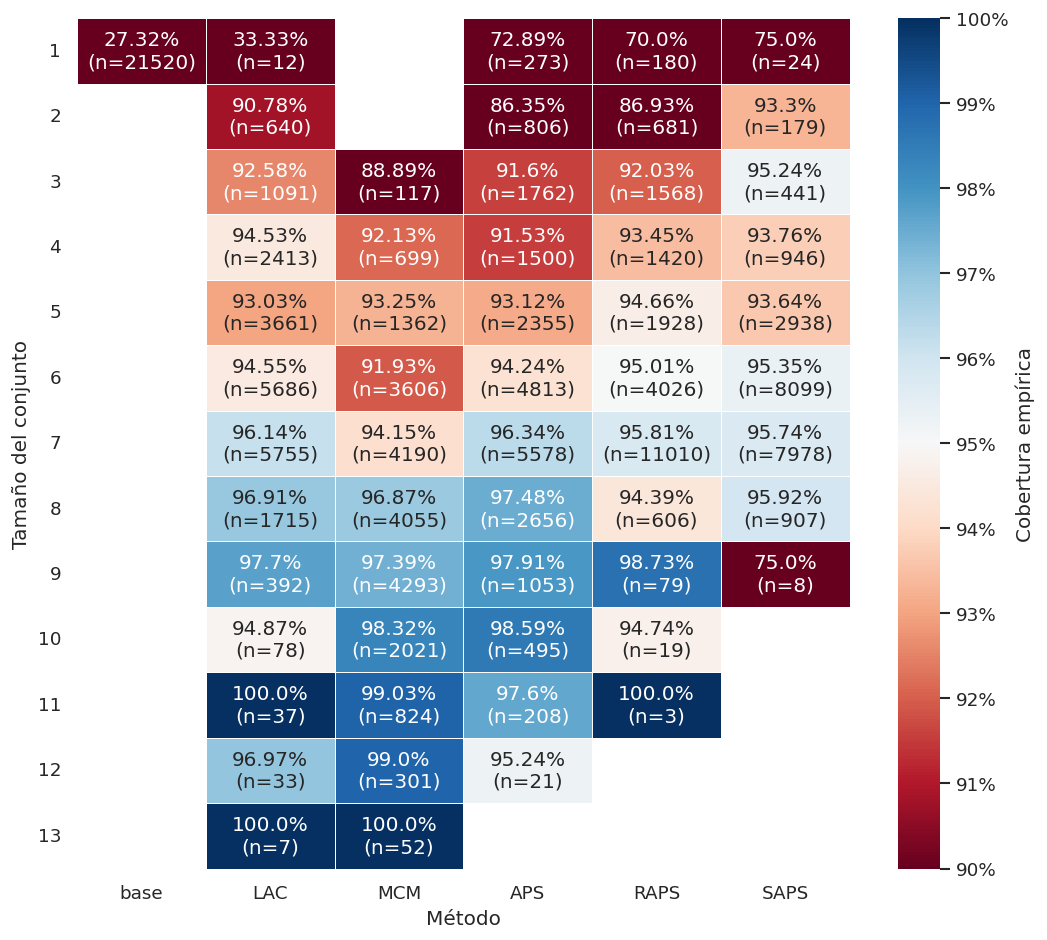

In [88]:
fig = plot_coverage_by_set_size(df_AGC_by_instance, figsize=(9,8), dpi=120)
plt.show()

## 3.5. Análisis de la cobertura en función de la edad cronológica

### Tabla resumen de cobertura y tamaño medio del conjunto de predicción por edad cronológica

In [69]:
df_AGC_by_instance_for_age = df_AGC_by_instance.copy()
df_AGC_by_instance_for_age['true_value_int'] = df_AGC_by_instance_for_age['true_class'].astype(int)+14

# display(df_AGC_by_instance_for_age)

df_AGC_by_true_age = (
    df_AGC_by_instance_for_age
    .groupby(['pred_model_type', 'confidence','true_value_int'])
    .agg(
        empirical_coverage=('is_covered', 'mean'),
        mean_set_size=('pred_set_size', 'mean')
    )
    .reset_index()
)

# Pivota para tener todas las métricas en columnas multi-nivel
df_AGC_by_true_age = df_AGC_by_true_age.pivot(
    index='true_value_int',
    columns=['pred_model_type', 'confidence'],
    values=['empirical_coverage', 'mean_set_size'] 
)

# Multiplica columnas de cobertura por 100
coverage_cols = [col for col in df_AGC_by_true_age.columns if 'empirical_coverage' in str(col)]
df_AGC_by_true_age[coverage_cols] = df_AGC_by_true_age[coverage_cols] * 100

# Muestra tabla con formato
styled_table = df_AGC_by_true_age.style.format("{:.2f}")
show(styled_table, allow_html=True)

/tmp/ipykernel_11550/978341728.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_model_type', 'confidence','true_value_int'])


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Gráfica

In [70]:
df_AGC_coverage_by_age = df_AGC_by_instance.copy()

#
df_AGC_coverage_by_age['true_value_int'] = df_AGC_coverage_by_age['true_class'].astype(int)+14

# Calcula la cobertura empírica por edad en entero
df_AGC_coverage_by_age = df_AGC_coverage_by_age.groupby(
    ['pred_model_type', 'confidence', 'true_value_int']
).agg(
    mean_coverage=('is_covered', 'mean'),  # % de cobertura empírica
    mean_set_size=('pred_set_size', 'mean'),  # Ancho promedio del intervalo en el decil
    count=('is_covered', 'count')  # Número de muestras en el decil
).reset_index()

df_AGC_coverage_by_age['mean_coverage'] = (df_AGC_coverage_by_age['mean_coverage'] * 100)

df_AGC_coverage_by_age = df_AGC_coverage_by_age[
    df_AGC_coverage_by_age['pred_model_type'].str.strip().str.lower() != 'base'
]

# Si es categoría, eliminarla del dtype
if pd.api.types.is_categorical_dtype(df_AGC_coverage_by_age['pred_model_type']):
    df_AGC_coverage_by_age['pred_model_type'] = df_AGC_coverage_by_age['pred_model_type'].cat.remove_unused_categories()

display(df_AGC_coverage_by_age)


/tmp/ipykernel_11550/1342447017.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_AGC_coverage_by_age = df_AGC_coverage_by_age.groupby(
/tmp/ipykernel_11550/1342447017.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_AGC_coverage_by_age['pred_model_type']):


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [71]:
df_AGC_coverage_by_age = df_AGC_coverage_by_age[df_AGC_coverage_by_age['pred_model_type']!='MCM']

/tmp/ipykernel_11550/2369287462.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


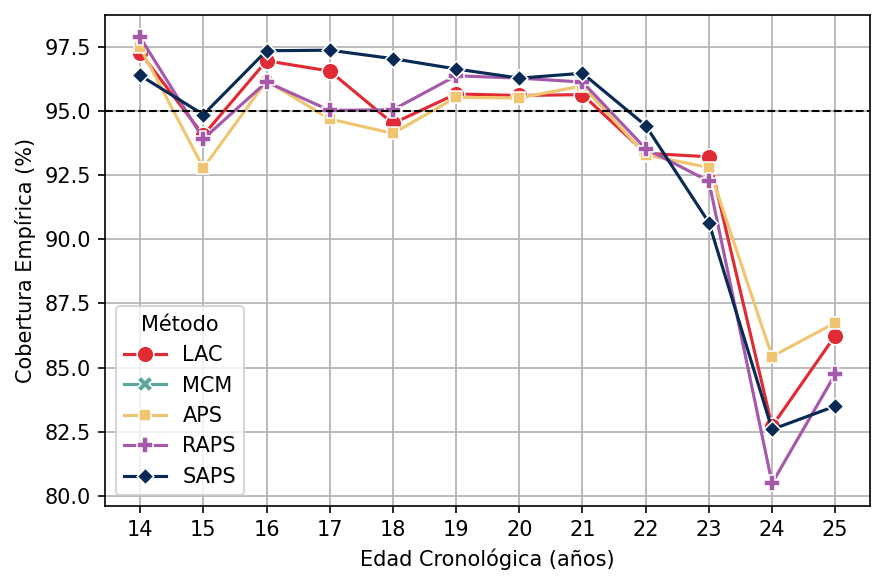

In [72]:
plt.figure(figsize=(6, 4), dpi=150)

color_dict = {'LAC': '#e02b35', 'MCM': '#59a89c', 
              'APS': '#f0c571', 'RAPS': '#a559aa', 'SAPS': '#082a54'}

lineplot = sns.lineplot(
    data=df_AGC_coverage_by_age,
    x='true_value_int',
    y='mean_coverage',
    hue='pred_model_type',
    style='pred_model_type',
    markers=True,
    dashes=False,
    palette=color_dict,
    ci=None  # si quieres puedes calcular intervalo de confianza, sino None para evitarlo
)

# Cambiar el tamaño de los marcadores
plt.setp(lineplot.lines, markersize=8)  # Ajusta el número a tu preferencia

plt.xlabel('Edad Cronológica (años)')
plt.ylabel('Cobertura Empírica (%)')
plt.legend(title='Método')
plt.grid(True)

plt.xticks(range(df_AGC_coverage_by_age['true_value_int'].min(),
                 df_AGC_coverage_by_age['true_value_int'].max() + 1, 1))

plt.axhline(y=95, color='black', linestyle='--', linewidth=1.0, zorder=2)

plt.tight_layout()
plt.show()

/tmp/ipykernel_11550/2108286542.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


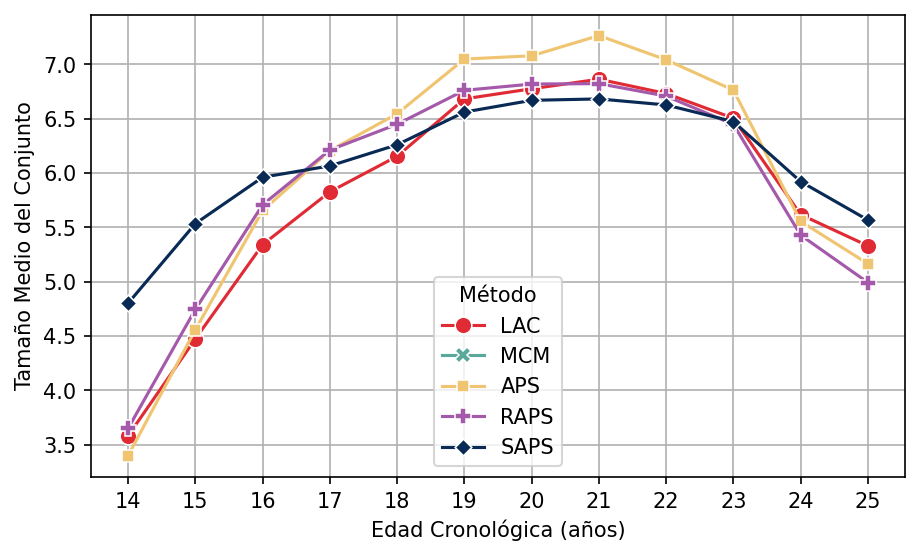

In [73]:
plt.figure(figsize=(7, 4), dpi=150)
lineplot = sns.lineplot(
    data=df_AGC_coverage_by_age,
    x='true_value_int',
    y='mean_set_size',
    hue='pred_model_type',
    style='pred_model_type',
    markers=True,
    dashes=False,
    ci=None,
    palette=color_dict
)
# Cambiar el tamaño de los marcadores
plt.setp(lineplot.lines, markersize=8)  # Ajusta el número a tu preferencia

plt.xlabel('Edad Cronológica (años)')
plt.ylabel('Tamaño Medio del Conjunto')
plt.xticks(range(int(df_AGC_coverage_by_age['true_value_int'].min()), 
                 int(df_AGC_coverage_by_age['true_value_int'].max()) + 1, 1))

plt.legend(title='Método')
plt.grid(True)
plt.show()

# PROBLEMA 4: ESTIMACIÓN DE CLASIFICACIÓN EN SEXO Y MAYORÍA DE EDAD

## 4.1. Carga de datos

In [ ]:
# Carga de datos
df_AMSC_by_instance = pd.read_csv('results/AMSC_maxillofacial_test_results.csv')

# Nueva columna: cobertura (true/false)
df_AMSC_by_instance['well_classified'] = (
    df_AMSC_by_instance['true_class'] == df_AMSC_by_instance['pred_class']
)

# Nueva columna: cobertura (true/false)
df_AMSC_by_instance['is_covered'] = (
    ((df_AMSC_by_instance['true_class'] == 0) & (df_AMSC_by_instance['pred_set_male_under_18']   == 1)) |
    ((df_AMSC_by_instance['true_class'] == 1) & (df_AMSC_by_instance['pred_set_male_over_18']    == 1)) |
    ((df_AMSC_by_instance['true_class'] == 2) & (df_AMSC_by_instance['pred_set_female_under_18'] == 1)) |
    ((df_AMSC_by_instance['true_class'] == 3) & (df_AMSC_by_instance['pred_set_female_over_18']  == 1))
)

# Nueva columna: tamaño del conjunto de predicción
df_AMSC_by_instance['pred_set_size'] = (
    df_AMSC_by_instance['pred_set_male_under_18'] 
    + df_AMSC_by_instance['pred_set_male_over_18']
    + df_AMSC_by_instance['pred_set_female_under_18'] 
    + df_AMSC_by_instance['pred_set_female_over_18']
)

# Nueva columna: set score
alpha = 1 - df_AMSC_by_instance['confidence']
df_AMSC_by_instance['set_score'] = (df_AMSC_by_instance['pred_set_size'] +
                                    1/alpha * (~df_AMSC_by_instance['is_covered']))

# Ordenar por iteración y por tipo de predicción
custom_order = ['base', 'LAC', 'MCM', 'APS', 'RAPS', 'SAPS']
df_AMSC_by_intance = sort_by_column(df_AMSC_by_instance, 'pred_model_type', custom_order, 
                                    secondary_column='iteration')

display(df_AMSC_by_instance)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [33]:
# Agrupar y calcular métricas
df_AMSC_by_run = (
    df_AMSC_by_instance
    .groupby(['pred_model_type', 'confidence', 'iteration'])
    .apply(lambda g: pd.Series({
        'accuracy': g['well_classified'].mean(),
        'empirical_coverage': g['is_covered'].mean(),
        'mean_set_size': g['pred_set_size'].mean(),
        'mean_set_score': g['set_score'].mean()
    }))
    .reset_index()
)

display(df_AMSC_by_run)

/tmp/ipykernel_9900/1060119993.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_model_type', 'confidence', 'iteration'])
/tmp/ipykernel_9900/1060119993.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## 4.2. Análisis de las métricas para la clasificación puntual de mayoría de edad y sexo

### Tabla resumen por método y ejecución

In [6]:
# Pivota para tener todas las métricas en columnas multi-nivel
pivot_point_metrics = df_AMSC_by_run.pivot(
    index='iteration',
    columns=['pred_model_type', 'confidence'],
    values=['accuracy'] 
)

# Reorganiza niveles para que las métricas estén en el nivel superior
pivot_point_metrics = pivot_point_metrics.swaplevel(axis=1).sort_index(axis=1)

In [7]:
# Calcular la media por método para cada métrica
pivot_point_with_mean = pd.concat([
    pivot_point_metrics,
    pivot_point_metrics.mean().to_frame().T.rename(index={0: 'Media'})
])

# Muestra con 2 decimales tanto MAE como MSE
styled_table = pivot_point_with_mean.style.format("{:.2f}")
show(styled_table, allow_html=True)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Análisis de la varianza

## 4.3. Análisis de las métricas para la clasificación de mayoría de sexo y edad en conjunto de predicción

### Tabla resumen por método y ejecución

In [8]:
# Pivotea para tener todas las métricas en columnas multi-nivel
pivot_interval_metrics = df_AMSC_by_run.pivot(
    index='iteration',
    columns=['pred_model_type', 'confidence'],
    values=['empirical_coverage', 'mean_set_size', 'mean_set_score'] 
)

# Reorganiza niveles para que las métricas estén en el nivel superior
pivot_interval_metrics = pivot_interval_metrics.swaplevel(axis=1).sort_index(axis=1)

In [9]:
# Define el orden deseado de las métricas
metric_order = ['empirical_coverage', 'mean_set_size', 'mean_set_score'] 

# Reindexa las columnas según el orden especificado
pivot_interval_metrics = pivot_interval_metrics.reindex(columns=metric_order, level=0)

In [10]:
# Calcular la media por método para cada métrica
pivot_with_mean = pd.concat([
    pivot_interval_metrics,
    pivot_interval_metrics.mean().to_frame().T.rename(index={0: 'Media'})
])

# Multiplicar columnas de cobertura por 100
coverage_cols = [col for col in pivot_with_mean.columns if 'empirical_coverage' in str(col)]
pivot_with_mean[coverage_cols] = pivot_with_mean[coverage_cols] * 100

# Mostrar tabla con formato
styled_table = pivot_with_mean.style.format("{:.2f}")
show(styled_table, allow_html=True)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Análisis de la varianza

### Gráfica de dispersión Cobertura empírica - Tamaño medio del conjunto

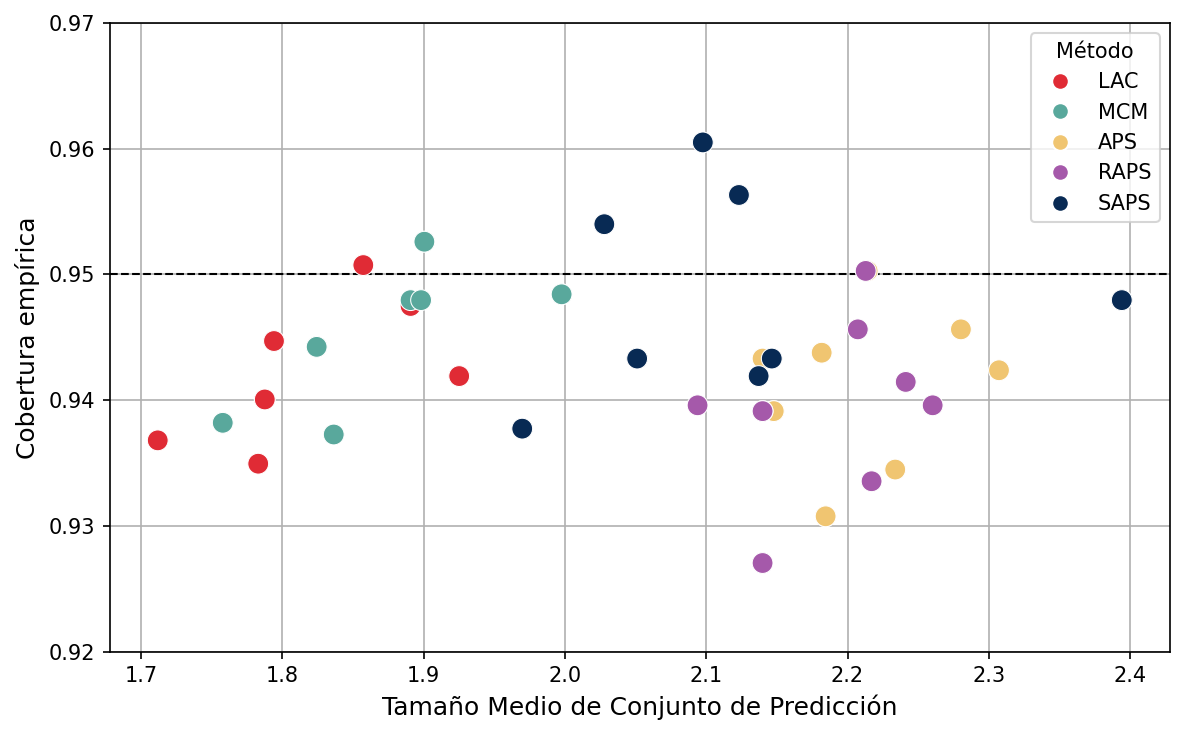

In [11]:
# Mapear colores
color_dict = {'base': '#7f7f7f', 'LAC': '#e02b35', 'MCM': '#59a89c', 
              'APS': '#f0c571', 'RAPS': '#a559aa', 'SAPS': '#082a54'}

df_AMSC_by_run_to_plot = df_AMSC_by_run[df_AMSC_by_run['pred_model_type']!='base'].copy()
# df_AMSC_by_run_to_plot = df_AMSC_by_run.copy()
df_AMSC_by_run_to_plot['color'] = df_AMSC_by_run_to_plot['pred_model_type'].map(color_dict)

#
plot_coverage_vs_set_size(
    mean_set_sizes=df_AMSC_by_run_to_plot['mean_set_size'],
    empirical_coverages=df_AMSC_by_run_to_plot['empirical_coverage'],
    model_types=df_AMSC_by_run_to_plot['pred_model_type'],
    colors=df_AMSC_by_run_to_plot['color'],
    confidence_level=0.95,
    figsize=(8, 5),
    dpi=150
)

## 4.4. Análisis de la cobertura por tamaño del conjunto de predicción

###  Tabla resumen de la cobertura por tamaño de intervalo para cada método

## 4.5. Análisis de la cobertura por clase

### Diagrama de Venn para conjuntos de predicciones